# Contents
### 1.  [Introduction](#1.-Introduction)
### 2.  [Import Libraries](#2.-Import-Libraries)
### 3.  [Helper Functions](#3.-Helper-Functions)
### 4.  [Load Dataset](#4.-Load-Dataset)
### 5.  [EDA (Explanatory-Data-Analysis)](#5.-EDA-(Explanatory-Data-Analysis))
    5.1 이상치 처리
    5.2 Target 피쳐 탐색
    5.3 Target 평균 시각화
    5.4 랜덤 샘플링 Target 시각화
    5.5 분위수 기준 Target 시각화
    5.6 SMA (Simple Miving Average)
    5.7 EMA (Exponential Moving Average)
    5.8 특정 code의 Target 시각화
    5.9 상위, 하위 Target 시각화
    5.10 시간 단위별 고유 code 개수
    5.11 종목별 기간 시각화
    5.12 NaN 분석
    5.13 상관관계 시각화
    5.14 F feature 탐색
    5.15 종목별, 시간 단위별 시각화
    5.16 train, test feature 분포 비교
    5.17 Adversarial Validation
    5.18 이진 분류 시각화
    5.19 PCA를 활용한 시각화
    5.20 이진분류 code별 target 시각화
    5.21 train, test의 code 비교
### 6.  [Conclusion](#6.-Conclusion)
<br>

# 1. Introduction

- 일정기간동안 측정된 주식 데이터셋을 기반으로 학습하여, 미래의 보지 못한 test set을 통해 prediction 하는 것이 주 목표이다.
- 데이터셋의 각 column은 날짜정보와 종목정보, 그리고 Feature set으로 이루어져 있으며, Feature set은 비식별화 처리되어 있다.
- Target 라벨은 다음 단위 시간의 수익률이 주어져 있으며, 연속값 혹은 5분위수 기준의 Target 두 가지가 있다.
- 이를 통해 데이터 탐색과 분석을 통해 regression 문제로 해결하거나 classification 문제로 해결하는 것이 과제이다.
- 코드는 EDA하는 파일과 모델링을 하는 파일 각각 나눠서 진행토록 하였다.


# 2. Import Libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%reload_ext line_profiler
%matplotlib inline

import os
import gc
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

# 3. Helper Functions

In [3]:
def SMA(df, target, num_windows=3):
    arr = np.array([])
    for code in df['code'].unique():
        temp_df = df.loc[df['code'] == code]
        arr = np.concatenate((arr, temp_df[target].rolling(window=num_windows).mean().values))
    return arr

def EMA(df, target, span_num=3):
    arr = np.array([])
    for code in df['code'].unique():
        temp_df = df.loc[df['code'] == code]
        arr = np.concatenate((arr, temp_df[target].ewm(span=span_num).mean().values))
    return arr

In [4]:
def pca_trace(target, color):
    tracer = go.Scatter(x = pca_data[pca_data["binary_target"] == target]["PC1"] ,
                        y = pca_data[pca_data["binary_target"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"))
    return tracer

def pca_apply(df, feat_cols, target_col):
    
    # scaling 이후 pca,target Up/Down 따로 시각화 (빨간색 - Up, 파란색 - Down)
    X = df[feat_cols]
    cols = [target_col, 'code']
    Y = df[cols]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X.dropna())

    pca = PCA(n_components = 2)
    principal_components = pca.fit_transform(X)
    pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
    pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
    pca_data["binary_target"] = pca_data["binary_target"].replace({1:"Up",0:"Down"})
    
    return pca_data

# 4. Load Dataset

In [5]:
DATASET_PATH = '../input'

X_train = pd.read_csv(os.path.join(DATASET_PATH, 'train_data.csv')) #훈련 데이터
Y_train = pd.read_csv(os.path.join(DATASET_PATH,'train_target.csv')) # 훈련 데이터에 대한 정답데이터 for regression
Y2_train = pd.read_csv(os.path.join(DATASET_PATH,'train_target2.csv')) # 훈련 데이터에 대한 정답데이터 for classification
test_df = pd.read_csv(os.path.join(DATASET_PATH,'test_data.csv')) # 테스트 데이터


In [6]:
X_train = X_train.set_index(['td', 'code'])
Y_train = Y_train.set_index(['td', 'code'])
Y2_train = Y2_train.set_index(['td', 'code'])

In [7]:
# 시각화 및 전처리부터 모델링까지 보다 편하게 수행하기 위해 새로운 데이터셋을 생성
Y2_train = Y2_train.rename(columns={'target':'binned_target'})

train_df = pd.merge(X_train, Y_train['target'], how='left', on=['td', 'code'])
train_df = pd.merge(train_df, Y2_train['binned_target'], how='left', on=['td', 'code'])
train_df['binary_target'] = train_df['target'].apply(lambda x: 1 if x >= 0 else 0)

train_df = train_df.reset_index()

In [8]:
print("shape of train set is: {} * {} (3 targets)".format(train_df.shape[0], train_df.shape[1]))
print("shape of test set is: {} * {}".format(test_df.shape[0], test_df.shape[1]))

shape of train set is: 83564 * 51 (3 targets)
shape of test set is: 11618 * 48


In [9]:
train_df.head()

td  code       F001      F002      F003      F004       F005      F006  \
0  T001  A005   7.267364  0.004896  0.945559 -0.828748   0.641026 -0.038719   
1  T001  A006  -7.477904 -0.000128  1.089255  0.042335   7.640449  0.038965   
2  T001  A007   7.622525  0.001413  1.260723  0.001667  13.735577  0.025740   
3  T001  A011  51.693204  0.000000  6.967351  0.268144 -11.543311  0.143675   
4  T001  A012  -7.707446 -0.000763  1.201887  0.285988  21.070234 -0.006894   

       F007      F008      F009      F010      F011      F012      F013  \
0  0.015282 -1.015634  1.136364  0.004044  0.011354  0.101754  71526.60   
1  0.016616 -0.631765  1.010101 -0.002093  0.017224 -0.124314  66762.59   
2  0.012530  6.140861  0.862069  0.001328  0.013585 -0.116173  43033.00   
3  0.033834  0.401105  0.185529  0.006380  0.033150  1.671017   5573.01   
4  0.017134  0.497051  0.833333  0.004365  0.016841 -0.350090  43167.36   

       F014       F015      F016      F017      F018      F019       F020  \
0  0.100316  -4.768937  4.792733 -0.043790  0.060811  0.002848  38.238227   
1  0.041121  -0.934142  3.893363  0.045088  0.027897 -0.002729   2.481333   
2  0.018358  12.650914  2.044551  0.028468  0.126005 -0.001062   3.891949   
3  0.096411   0.076096  0.131538  0.122475 -0.097907 -0.003738 -49.948921   
4  0.000900   3.438244  7.199411  0.024039  0.107034 -0.000582 -11.859685   

       F021       F022      F023       F024      F025      F026       F027  \
0  0.018440  -6.925412 -0.041526   6.302427  0.011433  0.001057   3.270022   
1  0.019590  -1.043675  0.040733  -2.531807  0.008215 -0.001656  -1.306523   
2  0.017248  24.251223  0.024875  -0.785996  0.018240  0.001696   9.377718   
3  0.030242  -7.443115  0.135400  43.068155  0.034070 -0.006647  17.515292   
4  0.020571  20.119292  0.023788  -9.390776  0.022019  0.004520 -13.472773   

       F028      F029       F030      F031       F032      F033      F034  \
0 -0.011596  0.026144   5.016722  0.955414  12.749842  0.000141  0.137546   
1  0.042740  0.014831  -2.244898  0.313152   1.775451  0.042377 -0.178182   
2  0.022911  0.052338  13.965816  1.598579  -0.263783  0.017256  0.032633   
3  0.088839  0.051290  56.189239  0.487805  -7.132306  0.091060  1.545997   
4  0.022126  0.083832 -21.645022  1.215470  -5.404140  0.022402 -0.324503   

        F035      F036      F037      F038      F039  F040      F041  \
0  48.333700 -0.043457 -1.567398  0.007646  0.002793   1.0  0.004724   
1   3.555757  0.042450 -1.033058 -0.001463 -0.002713   2.0 -0.004431   
2   4.309684  0.028468  7.648485  0.003168 -0.000951   6.0 -0.004544   
3 -36.111240  0.118397  1.358087  0.037001 -0.004078   2.0  0.012924   
4  -2.475818  0.023296  0.835655 -0.059726 -0.000538   5.0 -0.000045   

       F042        F043      F044        F045       F046    target  \
0 -1.041667   13.357401  0.793424   11.347518   0.544470 -0.041401   
1  2.040816  -14.464286  0.546866   -4.960317   3.914780 -0.010438   
2  0.000000   13.052749  0.523903   -1.228115   9.910044 -0.042630   
3 -7.142857  156.242771  1.050259  137.679277  -2.979930  0.109743   
4  0.000000  -17.351598  0.865144  -17.539863  12.087614  0.058011   

   binned_target  binary_target  
0              0              0  
1              2              0  
2              0              0  
3              4              1  
4              4              1

In [10]:
test_df.head()

td  code       F001      F002      F003      F004       F005      F006  \
0  T275  A005  15.834757 -0.004040  1.175874  0.000243  -4.702970 -0.039944   
1  T275  A006   8.992218 -0.000675  0.947045 -0.030466  -0.709220  0.027105   
2  T275  A007   4.184298  0.002019  0.722963  0.102586 -13.975904  0.037740   
3  T275  A008 -17.642056 -0.003666  1.671914 -0.015421  -2.547771  0.058734   
4  T275  A012  38.383748  0.001836  1.166738  0.000000   9.698997  0.054793   

       F007      F008      F009      F010      F011      F012       F013  \
0  0.027050 -4.023189  0.961538 -0.004196  0.026496  0.384892  132371.72   
1  0.027855  1.479513  1.123596 -0.000364  0.023157  0.228070   78052.29   
2  0.020610 -4.317447  1.470588  0.001015  0.020428 -0.002793   31880.10   
3  0.022762 -6.463780  0.657895 -0.004132  0.022794 -0.422642   10098.00   
4  0.034665 -2.378564  0.952381  0.002573  0.030942  1.027194   39112.97   

       F014      F015      F016      F017      F018      F019       F020  \
0 -0.021149  1.179678 -4.005763 -0.044005 -0.056373 -0.008800  -2.334319   
1  0.003559 -0.091223  3.972779  0.017821  0.052632 -0.000728   8.175437   
2  0.038620 -7.266795 -2.221317  0.028139 -0.122850  0.002030  -1.945334   
3  0.053517  0.899596  4.374315  0.049083 -0.153137 -0.008264   6.055867   
4  0.047919 -1.198798 -1.453870  0.036503 -0.015015  0.005147  45.742830   

       F021       F022      F023       F024      F025      F026       F027  \
0  0.025701   3.538187 -0.050471   2.382296  0.022150  0.002112  -4.127811   
1  0.021744  -1.856362  0.017970   8.592721  0.021021 -0.001014  11.026623   
2  0.016523 -67.676617  0.030777  -7.692486  0.022934  0.001736  -1.810701   
3  0.024014  -4.698926  0.040770 -13.987664  0.016147 -0.004687 -15.700870   
4  0.027780  14.154323  0.044159  31.166663  0.026132  0.004202  19.148615   

       F028      F029       F030      F031      F032      F033      F034  \
0 -0.039577  0.000000 -10.879630  0.519481 -8.697215 -0.049494  0.567273   
1  0.016522  0.023766  26.696833  0.535714  5.881080  0.016562  0.272727   
2  0.027068 -0.092757  -3.120760  3.081232 -5.557482  0.030604  0.233883   
3  0.027798 -0.046729 -39.525692  2.047930 -7.504074  0.020904 -0.429952   
4  0.034200  0.044586  65.156093  1.189024  6.327480  0.039180  0.796117   

        F035      F036       F037      F038      F039  F040      F041  \
0 -19.208631 -0.047416 -10.672854  0.015422 -0.009397   1.0 -0.012452   
1   8.205910  0.017505   4.089219  0.002015 -0.000447   2.0  0.000019   
2  -0.285448  0.028139  -9.044586  0.014919  0.002052   6.0  0.004690   
3 -21.158269  0.040953 -14.365672 -0.133613 -0.001011   4.0 -0.001194   
4  80.208884  0.041598  -8.123249  0.028009  0.007012   5.0  0.009573   

       F042        F043      F044       F045      F046  
0  0.000000   40.510949  0.994388   6.353591 -2.035956  
1  1.470588   19.402985  0.980344  19.148936 -0.434839  
2 -1.000000    6.886228  1.166253 -12.926829 -6.614890  
3 -3.174603  -42.336683  1.084645 -35.077793 -1.165099  
4  0.000000  105.771644  0.821431  95.005945  2.817153

# 5. EDA (Explanatory Data Analysis)

<br>
- 모델링을 하기에 앞서서 EDA를 통해 데이터를 이해하는 과정은 꼭 선행되어야 한다.
<br>
- EDA를 하는 과정에서 인사이트를 발견할 수 있을 뿐만 아니라, 모델링에 대한 아이디어도 얻을 수 있기 때문이다. 

In [11]:
# td 피쳐를 기반으로 시각화를 위한 time 피쳐 생성
train_df['td'] = train_df['td'].str[1:].astype('int')
test_df['td'] = test_df['td'].str[1:].astype('int')

In [12]:
# 칼럼 처리의 편의성을 위해 총 4개의 column으로 구분하자. time/code/feature/target
feat_cols = [col for col in train_df.columns if col.startswith('F')]
target_cols = [col for col in train_df.columns if col in ['target', 'binned_target', 'binary_target']]

우선 train과 test의 시간 단위가 어떻게 다른지 살펴보자

In [13]:
# train과 test의 시간 단위의 시작과 끝 살펴보기
num_train_times = train_df['td'].max() - train_df['td'].min() + 1
num_test_times = test_df['td'].max() - test_df['td'].min() + 1
print("train set time ranges from {} to {} which is {} tds".format(train_df['td'].min(), train_df['td'].max(), num_train_times))
print("test set time ranges from {} to {} which is {} tds".format(test_df['td'].min(), test_df['td'].max(), num_test_times))

train set time ranges from 1 to 274 which is 274 tds
test set time ranges from 275 to 310 which is 36 tds


train은 1부터 274 시간 단위까지이고, 
<br>
test set은 train이 끝난 직후부터 시작된다는 것을 알 수 있다.
<br>

## 5.1 이상치 처리

4.8 part에서 시각화 해 본 결과, 단 하루만 등장하는 code가 있다는 것을 발견하였다.
<br>
시간 단위 기준으로 몇 번 등장하지 않는 것은 모델링에 안좋은 영향을 끼칠 것이라 판단하여 등장 횟수 3번 이하는 이상치라 판단하고 제거하였다.
<br>

In [14]:
temp_dict = Counter(train_df['code'])
outlier_codes = [k for k, v in set(temp_dict.items()) if v <= 3]
train_df = train_df.loc[~train_df['code'].isin(outlier_codes)]

## 5.2 Target 피쳐 탐색

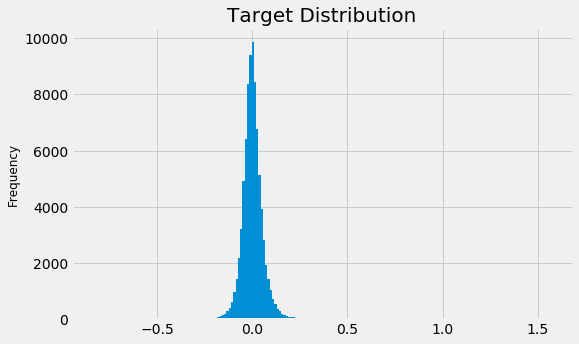

In [15]:
# target의 분포 확인
plt.figure(figsize=(8,5))
train_df['target'].plot(kind='hist', bins=200)
plt.ylabel('Frequency', fontsize=12)
plt.title("Target Distribution", fontsize=20)
plt.show()

target은 정규 분포 형태를 띄는 것을 확인할 수 있다.

## 5.3 Target 평균 시각화

In [16]:
# target 평균 시각화
data = []

temp_df = train_df.groupby(['td'])['target'].mean().reset_index()

data.append(go.Scatter(
    x = temp_df['td'].values,
    y = temp_df['target'].values,
    ))
layout = go.Layout(dict(title = 'Trend of Earning Ratio (target) Mean',
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

위의 시각화는 시간 단위에 따른 평균 target이다. 

## 5.4 랜덤 샘플링 Target 시각화

몇 개의 code를 샘플링하여 예측하고자 하는 target의 추세를 먼저 시각화 해보자

In [17]:
# 랜덤하게 num_view 만큼의 code를 샘플링하여 target 변수를 시각화 (실행할 때마다 다른 샘플 시각화)
data = []
num_view = 3
for code in np.random.choice(train_df['code'].unique(), num_view):

    temp_df = train_df[(train_df['code'] == code)]    
    data.append(go.Scatter(
        x = temp_df['td'].values,
        y = temp_df['target'].values,
        name = code
    ))

layout = go.Layout(dict(title = f"{num_view} Random codes",
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ),legend=dict(orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

랜덤하게 샘플링을 해서 시각화를 해보면 알 수 있듯이, 어떤 code는 생겨났다가 없어지기도 한다.
<br>
없어지는 이유로는 파산이나 합병 혹은 다른 이유가 있을 것으로 예상할 수 있다.
<br>

## 5.5 분위수 기준 Target 시각화

In [18]:
# 분위수 기준으로 target 시각화
data = []

for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    temp_df = train_df.groupby(['td'])['target'].quantile(i).reset_index()
    
    data.append(go.Scatter(
        x = temp_df['td'].values,
        y = temp_df['target'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = 'Trend of Earning Ratio (target) by quantiles',
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ),legend=dict(orientation='h'))
py.iplot(dict(data=data, layout=layout), filename='basic-line')


위와 같이 시간에 따른 분위수를 기준으로 트랜드를 시각화를 진행해 볼 수 있다.
<br>
보면 가로축 특정 시간 140 부근에서 target이 급락했던 것을 확인할 수 있다. 

## 5.6 SMA (Simple Moving Average)

<br>
단순이동평균은 해당 기간과 이전 기간의 데이터를 평균내는 방법이다.
<br>
이렇게 이전 기간의 데이터를 활용함으로써 최근 트렌드를 현재 시간에 반영할 수 있다.
<br>
이동평균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
<br>
단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.

$$ SMA_t = \frac{D_{t-(n-1)} + D_{t-(n-2)} + \cdots + D_{t-1} + D_t}{n} $$
<br>

In [19]:
# SMA 시각화 코드
train_sorted_df = train_df.sort_values(by=['code', 'td']).reset_index(drop=True).copy()
train_sorted_df['SMA_3'] = SMA(train_sorted_df, 'target', 3)

data = []

temp_df = train_sorted_df.groupby(['td'])['SMA_3'].mean().reset_index()

data.append(go.Scatter(
    x = temp_df['td'].values,
    y = temp_df['SMA_3'].values,
    ))
layout = go.Layout(dict(title = 'Simple Moving Average of 3 td (target)',
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')


train_sorted_df['SMA_20'] = SMA(train_sorted_df, 'target', 20)

data = []

temp_df = train_sorted_df.groupby(['td'])['SMA_20'].mean().reset_index()

data.append(go.Scatter(
    x = temp_df['td'].values,
    y = temp_df['SMA_20'].values,
    ))
layout = go.Layout(dict(title = 'Simple Moving Average of 20 td (target)',
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

## 5.7 EMA (Exponetial Moving Average)

지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법이다.


$$ EMA_t = D_t \times \frac{2}{N + 1} + EMA_{t-1} \times (1 - \frac{2}{N + 1}) $$
<br>

In [20]:
# EMA 시각화 코드
train_sorted_df['EMA_3'] = EMA(train_sorted_df, 'target', 3).copy()

data = []

temp_df = train_sorted_df.groupby(['td'])['EMA_3'].mean().reset_index()

data.append(go.Scatter(
    x = temp_df['td'].values,
    y = temp_df['EMA_3'].values,
    ))
layout = go.Layout(dict(title = 'Exponetial Moving Average of 3 td (target)',
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')


train_sorted_df['EMA_20'] = EMA(train_sorted_df, 'target', 20)

data = []

temp_df = train_sorted_df.groupby(['td'])['EMA_20'].mean().reset_index()

data.append(go.Scatter(
    x = temp_df['td'].values,
    y = temp_df['EMA_20'].values,
    ))
layout = go.Layout(dict(title = 'Exponetial Moving Average of 20 td (target)',
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

## 5.8 특정 code의 Target 시각화

In [21]:
# 살펴보고 싶은 code 입력
code = 'A004'

In [22]:
# 특정 code의 target 시각화
data = []
temp_df = train_df.loc[train_df['code'] == code]
data.append(go.Scatter(
    x = temp_df['td'].values,
    y = temp_df['target'].values,
    name = code
))
layout = go.Layout(dict(title = f"code: {code}",
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ),legend=dict(orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

code 하나씩 시각화하여 살펴보면 꼭 모든 시간 단위의 데이터가 있지 않은 것을 확인할 수 있다. 

In [23]:
temp_df = train_df.set_index(['code', 'td'])
temp_df = temp_df.sort_values(['code', 'td'])

In [24]:
temp_df.loc['A004'].index

Int64Index([129, 130, 131, 132, 133, 141, 159, 188, 190, 191, 192, 196, 197,
            198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
            211, 213, 214, 219, 220, 227, 228, 229, 230, 231, 232, 233, 234,
            235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
            248, 249, 250, 252, 253, 254],
           dtype='int64', name='td')

또한 이렇게 code별로 묶어서 살펴보면 중간 중간에 데이터가 비어있는 것을 다시금 확인할 수 있다.
<br>
시간 단위 및 피쳐들이 비식별화 되어 있기 때문에 완전히 이해하기는 힘들다

## 5.9 상위, 하위 Target 시각화

다음과 같이 target을 기준으로 상위 몇 개와 하위 몇 개를 살펴볼 수도 있다.

In [25]:
# 보고자 하는 상위, 하위 code(종목) 개수 
num = 10

In [26]:
# code별로 target을 평균내어 정렬하는 코드
sorted_df = train_df.groupby(['code'])['target'].mean().to_frame().sort_values(by='target', ascending=True).reset_index()

print(f"bottom {num}")
print("code  target")
for code, target in zip(sorted_df['code'][:num], sorted_df['target'][:num]):
    print("{}  {:.4f}".format(code, target))
    
sorted_df = train_df.groupby(['code'])['target'].mean().to_frame().sort_values(by='target', ascending=False).reset_index()

num = 10
print(f"\ntop {num}")
print("code  target")
for code, target in zip(sorted_df['code'][:num], sorted_df['target'][:num]):
    print("{}  {:.4f}".format(code, target))
    

bottom 10
code  target
A403  -0.1588
A695  -0.1446
A499  -0.1195
A088  -0.0842
A783  -0.0772
A399  -0.0712
A656  -0.0605
A091  -0.0602
A589  -0.0597
A064  -0.0509

top 10
code  target
A472  0.3039
A572  0.1168
A534  0.0846
A235  0.0762
A341  0.0731
A209  0.0564
A739  0.0471
A751  0.0415
A672  0.0385
A231  0.0345


target 수익률을 기준으로 상위 10등과 하위 10등을 시각화 해보자

In [27]:
top_num = 10

In [28]:
# top_num 만큼의 상위 code 시각화
data = []
for code in sorted_df['code'][:top_num]:

    temp_df = train_df[(train_df['code'] == code)]    
    data.append(go.Scatter(
        x = temp_df['td'].values,
        y = temp_df['target'].values,
        name = code
    ))

layout = go.Layout(dict(title = f"Top {top_num} codes",
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ),legend=dict(orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

수익률이 높은 code 중에는 굉장히 단기간에 치중되어 것들이 많다.

In [29]:
lowest_num = 10

In [30]:
# lowest_num 만큼의 하위 code 시각화
data = []
for code in sorted_df['code'][-lowest_num:]:

    temp_df = train_df[(train_df['code'] == code)]    
    data.append(go.Scatter(
        x = temp_df['td'].values,
        y = temp_df['target'].values,
        name = code
    ))

layout = go.Layout(dict(title = f"Lowest {lowest_num} codes",
                  xaxis = dict(title = 'Time'),
                  yaxis = dict(title = 'Earning Ratio (target)'),
                  ),legend=dict(orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

이 코드를 통해서 시각화 처음 살펴 본 결과, 단 하루만 등장하는 종목들이 꽤 있다는 것을 발견하였다.
<br>
따라서 초기 EDA 파트에서 1~3 시간 단위만 등장하는 code들을 이상치라 판단하고 제거하였다.
<br>

## 5.10 시간 단위별 고유 code 개수 

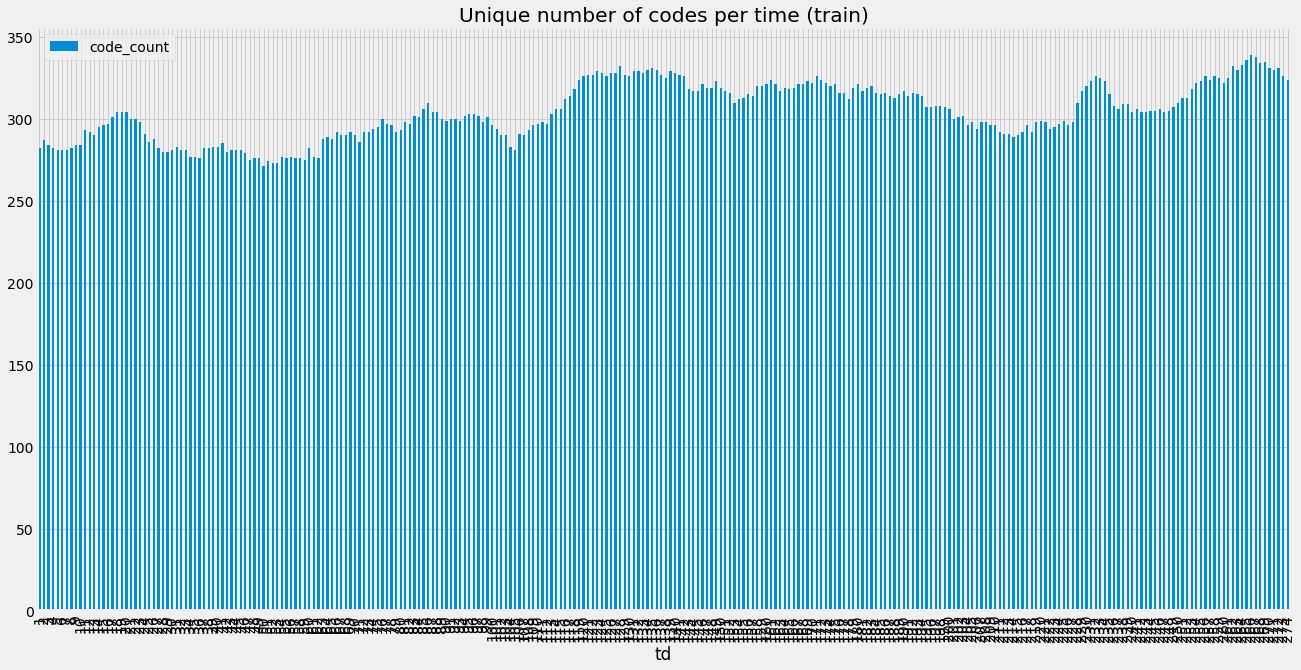

In [30]:
# train set에서 단위 시간별로 고유 code의 개수 시각화
temp_df = train_df.groupby('td')['code'].count().to_frame().reset_index(). \
                    rename(columns={'code':'code_count'})

temp_df.plot(kind='bar', x='td', y='code_count', figsize=(20, 10), title='Unique number of codes per time (train)')
plt.show()

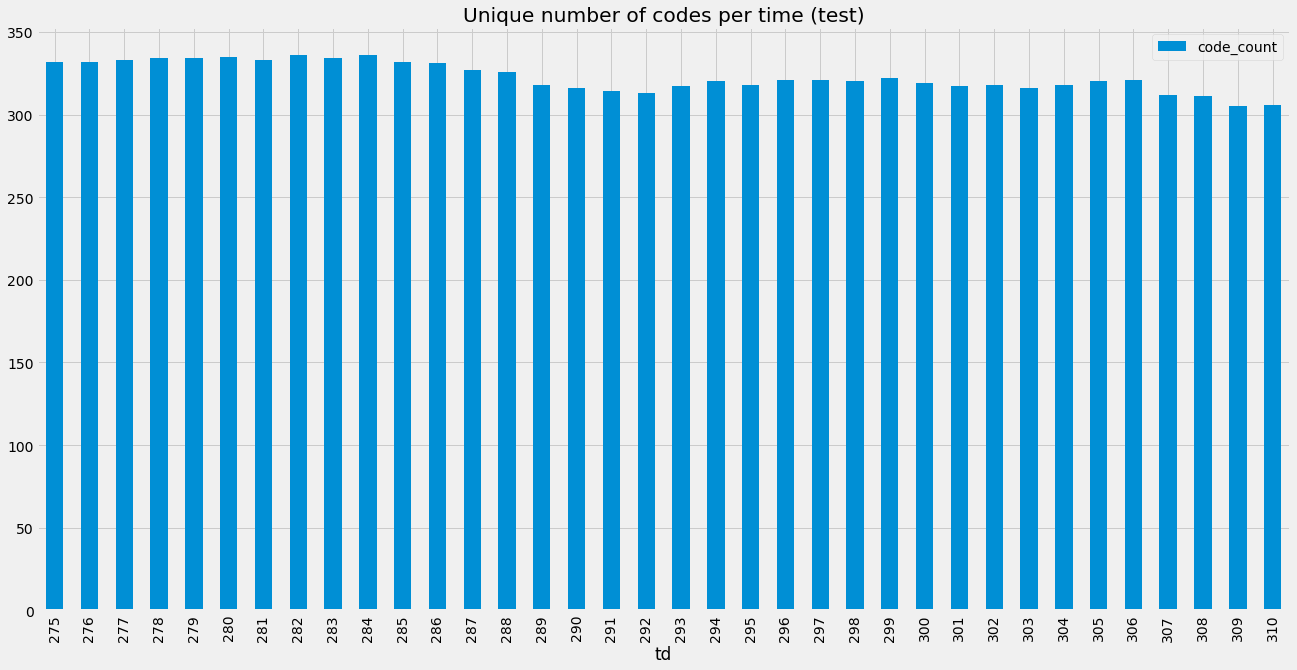

In [31]:
# test set에서 단위 시간별로 고유 code의 개수 시각화
temp_df = test_df.groupby('td')['code'].count().to_frame().reset_index(). \
                    rename(columns={'code':'code_count'})

temp_df.plot(kind='bar', x='td', y='code_count', figsize=(20, 10), title='Unique number of codes per time (test)')
plt.show()

시각화를 해보면 알 수 있듯이, train, test의 일별 고유 code 갯수는 같지 않다.

## 5.11 종목별 기간 시각화

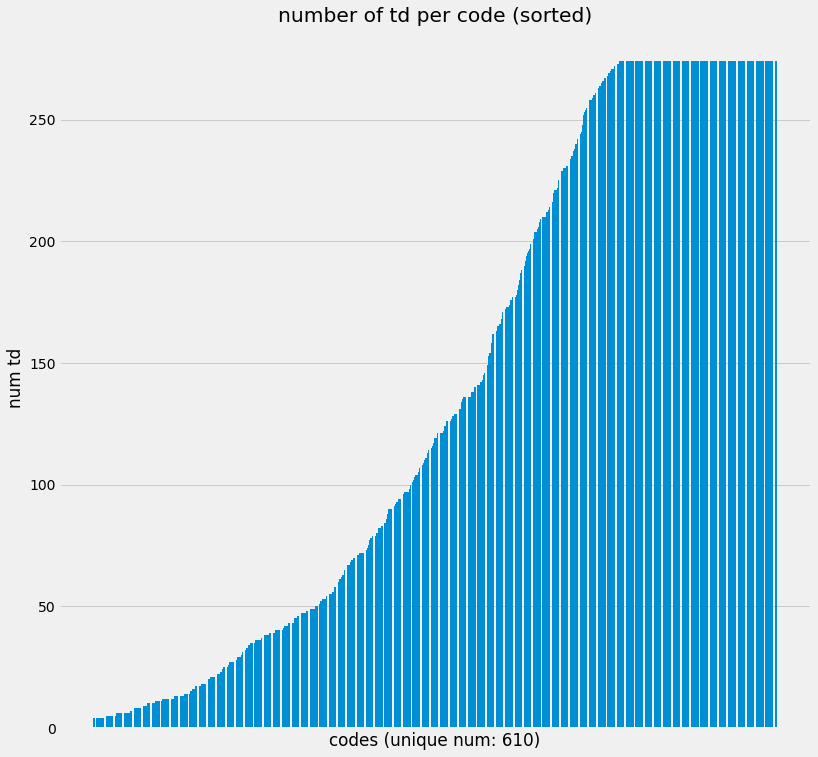

In [32]:
# code별로 기간을 정렬하여 시각화
code_td_num_dict = {}
for code in train_df['code'].unique():
    td_num = len(train_df[train_df['code'] == code])
    code_td_num_dict[code] = td_num

# td 개수 기준으로 code 정렬
code_td_num_dict = {k:v for k, v in sorted(code_td_num_dict.items(), key=lambda item: item[1], reverse=False)}

plt.figure(figsize=(12, 12))
plt.bar(range(len(code_td_num_dict)), list(code_td_num_dict.values()), align='center')
plt.title('number of td per code (sorted)')
plt.xticks([])
plt.xlabel('codes (unique num: 610)')
plt.ylabel('num td')
plt.show()

기간 내내 등장하는 종목(code)이 있는 반면에, 기간 내내 별로 등장하지 않는 종목도 존재한다는 것을 알 수 있다.
<br>
(part 4.1에서 3번 이하 등장하는 code는 제거함)
<br>

## 5.12 NaN 분석

In [34]:
total_train_feat_num = train_df.shape[0] * len(feat_cols)
total_train_nans = train_df.isnull().sum().sum()
total_test_feat_num = test_df.shape[0] * len(feat_cols)
total_test_nans = test_df.isnull().sum().sum()

print("train set에는 총 {}개의 NaN 값이 존재 (전체의 약 {:.2f}%)".format(total_train_nans, total_train_nans / total_train_feat_num * 100))
print("test set에는 총 {}개의 NaN 값이 존재 (전체의 약 {:.2f}%)".format(total_test_nans, total_test_nans / total_test_feat_num * 100))

train set에는 총 220638개의 NaN 값이 존재 (전체의 약 5.75%)
test set에는 총 38920개의 NaN 값이 존재 (전체의 약 7.28%)


NaN 값에 대해서 좀 더 자세히 들여다보자.

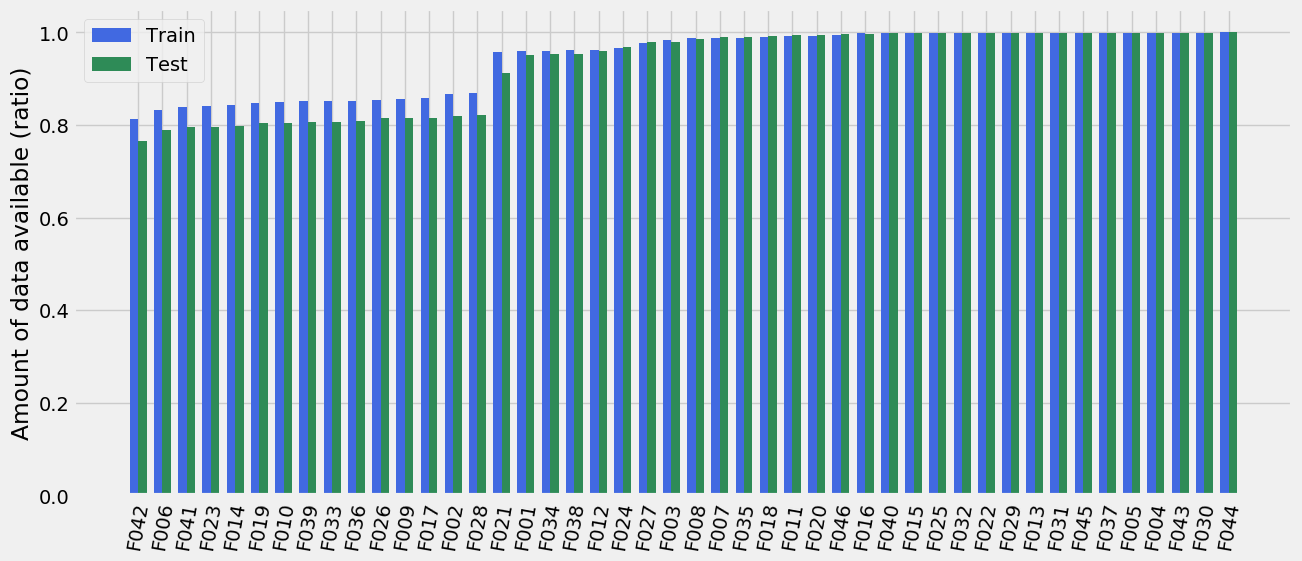

In [35]:
# train과 test 피쳐 칼럼들의 Nan 비율 시각화
train_data = (train_df.count() / len(train_df)).drop(['td', 'code', 'target', 'binned_target', 'binary_target']).sort_values().values

ind = np.arange(len(train_data))
width = 0.35
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test_df.count() / len(test_df)).drop(['td', 'code']).sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available (ratio)');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train_df.count() / len(train_df)).drop(['td', 'code', 'target', 'binned_target', 'binary_target']).sort_values().index, rotation=80)
axes.legend([tr, tt], ['Train', 'Test']);

Train과 Test에 대한 nan값을 비교해 봤을 때, 특정 피쳐에서 nan 비율이 train이 약간 더 높다는 것을 확인할 수 있다.

이번에는 종목 별로 NaN 값의 비율을 살펴보자.

In [36]:
# NaN analysis per code
NaN_dict = {}

for i, code in enumerate(train_df['code'].unique()):
    temp_df = train_df[train_df['code'] == code]
    null_num = temp_df.isnull().sum().sum()
    feat_num = temp_df[feat_cols].shape[0] * temp_df[feat_cols].shape[1]
    uniqeu_td_num = len(temp_df)
    NaN_dict[code] = [null_num, np.round((null_num/feat_num)*100, 2), feat_num, uniqeu_td_num]

    
temp_df = pd.DataFrame.from_dict(NaN_dict, orient='index').reset_index() \
                                .rename(columns={'index':'code', 0:'Nan_count', 1:'Nan_ratio', 2:'feat_num', 3:'unique_td_num'}) \
                                .sort_values(by='Nan_ratio', ascending=False).reset_index(drop=True)

In [37]:
temp_df.head(10)

code  Nan_count  Nan_ratio  feat_num  unique_td_num
0  A561        381      63.71       598             13
1  A088        142      61.74       230              5
2  A102        385      59.78       644             14
3  A477        108      58.70       184              4
4  A192        480      57.97       828             18
5  A459        574      54.25      1058             23
6  A611        499      54.24       920             20
7  A446        447      53.99       828             18
8  A152        198      53.80       368              8
9  A247        539      53.26      1012             22

위와 같이 code (종목)별로 Nan의 총 개수와 그 비율을 확인해 볼 수 있다.
<br>
종목 별로, 피쳐 별로 더 살펴볼 수도 있으나, 코드 양이 너무 많아지기 때문에 넘어가도록 한다.
<br>
아래와 같이 시각화하여 전반적인 추세를 살펴볼 수도 있다.

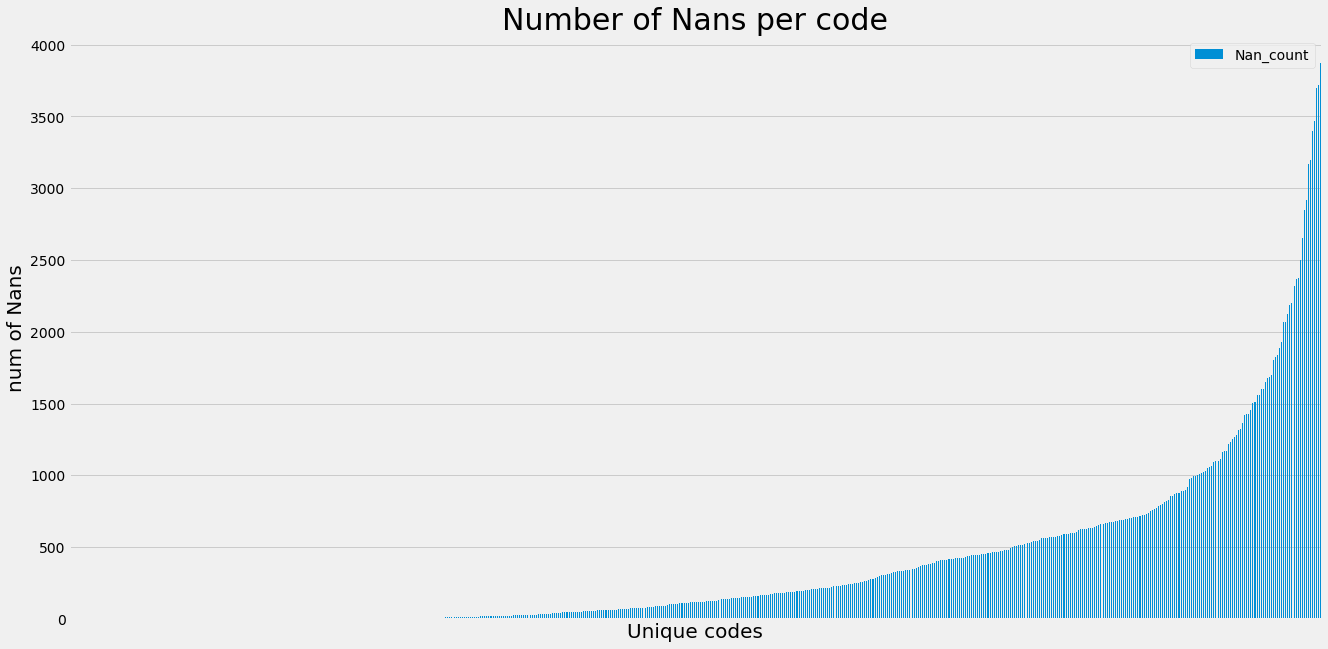

In [38]:
temp_df = pd.DataFrame.from_dict(NaN_dict, orient='index').reset_index() \
                                .rename(columns={'index':'code', 0:'Nan_count', 1:'Nan_ratio'}) \
                                .sort_values(by='Nan_count').reset_index(drop=True)

temp_df.plot(kind='bar', x='code', y='Nan_count', figsize=(20, 10))

plt.title('Number of Nans per code', fontsize=30)
plt.xticks([])
plt.xlabel('Unique codes', fontsize=20)
plt.ylabel('num of Nans', fontsize=20)
plt.show()

In [39]:
temp_df[['code', 'Nan_count']].sort_values(by='Nan_count', ascending=False)[:10].reset_index(drop=True)

code  Nan_count
0  A581       3870
1  A370       3720
2  A504       3695
3  A786       3469
4  A188       3399
5  A708       3195
6  A391       3167
7  A146       2919
8  A355       2848
9  A110       2655

Missing Value가 가장 많은 code 순으로 정렬한 결과하여 상위 10개만 뽑아본 결과는 위와 같다.

In [40]:
print("반면 Missing Value가 0인 code(종목)은 {}개".format(len(temp_df[temp_df['Nan_count'] == 0])))

반면 Missing Value가 0인 code(종목)은 144개


### NaN 값은 어떻게 채워야 할까?

크게 세 가지 방법으로 나눠보면, 
<br>
**1. NaN값이 존재하는 row를 drop한다** 
<br>
**2. 특정 값으로 채워넣는다**
<br>
<br>
첫 번째 방법 같은 경우를 적용할 경우, 상당히 많은 데이터가 사라지기 때문에 채워넣는 방법을 선택하기로 하였다.
<br>

<br>
두 번째 방법을 선택하였을시, 어떤 값으로 채워야 하는지 고민이 될 것이다.
<br>
0을 채워넣거나 흔히 트리 계열의 모델을 학습할 때 채워넣는 -999 같은 값을 넣는다면, 시계열 데이터의 특성을 완전히 망쳐버리는 결과를 낼 수 있다.
<br>
따라서 Naive하지만 NaN 값을 채울 때, code (종목) 별로 고려해서 채워나가는 것이 합리적이라 판단을 하고 다음과 같이 채워넣고자 하였다.
<br>


In [41]:
# example data
df = pd.DataFrame([[1, np.nan, np.nan, np.nan, 1],
                   [2, np.nan, np.nan, np.nan, 2],
                   [3, 5, np.nan, np.nan, 3],
                   [4, 4, 1, np.nan, 4],
                   [5, 3, 2, 4, 5]],
                   columns=['td', 'A', 'B', 'C', 'weight'])
df

td    A    B    C  weight
0   1  NaN  NaN  NaN       1
1   2  NaN  NaN  NaN       2
2   3  5.0  NaN  NaN       3
3   4  4.0  1.0  NaN       4
4   5  3.0  2.0  4.0       5

데이터셋은 위와 같이 값이 어떤 특정 시간 단위부터 값이 나타나거나, 피쳐의 모든 값이 NaN이거나 둘 중 하나이다.
<br>
따라서 code(종목)별로 최근 시간에 더 가중치를 두어 평균을 계산한다음 피쳐의 missing value를 채우고
<br>
해당 피쳐의 모든 값이 NaN이면 모든 코드의 피쳐 평균을 채워넣기로 한다.

In [42]:
# 데이터셋 NaN 전처리
def preprocess_nan(df, feat_cols):

    preprocessed_df = pd.DataFrame()

    # code(종목)별, 피쳐별로 NaN 값을 채우되, 최근 시간에 더 가중치를 두고 계산한다.
    for code in df['code'].unique():
        code_df = df[df['code'] == code].copy()

        for i, feat_col in enumerate(code_df[feat_cols]):

            temp_df = code_df[feat_col].dropna().to_frame()

            if len(temp_df) == len(code_df):
                continue

            temp_df['weight'] = [i for i in range(len(temp_df), 0, -1)]

            try:
                fill_value = np.average(temp_df[feat_col], weights=temp_df['weight'])
                code_df[feat_col].fillna(fill_value, inplace=True)

            # 해당 피쳐에 모든 값이 NaN일 경우 넘어간다.
            except:
                continue

        preprocessed_df = preprocessed_df.append(code_df)
        
    del code_df, temp_df; gc.collect()
    
    # 해당 code(종목)의 feature에 모든 값이 NaN일 경우 모든 종목의 피쳐 평균값으로 NaN을 채운다.  
    for feat_col in feat_cols:
        mean_val = preprocessed_df[feat_col].mean()
        preprocessed_df[feat_col].fillna(mean_val, inplace=True)

    return preprocessed_df

In [43]:
# NaN preprocess
preprocessed_train_df = preprocess_nan(train_df, feat_cols)
preprocessed_test_df = preprocess_nan(test_df, feat_cols)

print("number of missing values in train set: {}".format(preprocessed_train_df.isnull().sum().sum()))
print("number of missing values in test set: {}".format(preprocessed_test_df.isnull().sum().sum()))

number of missing values in train set: 0
number of missing values in test set: 0


## 5.13 상관관계 시각화

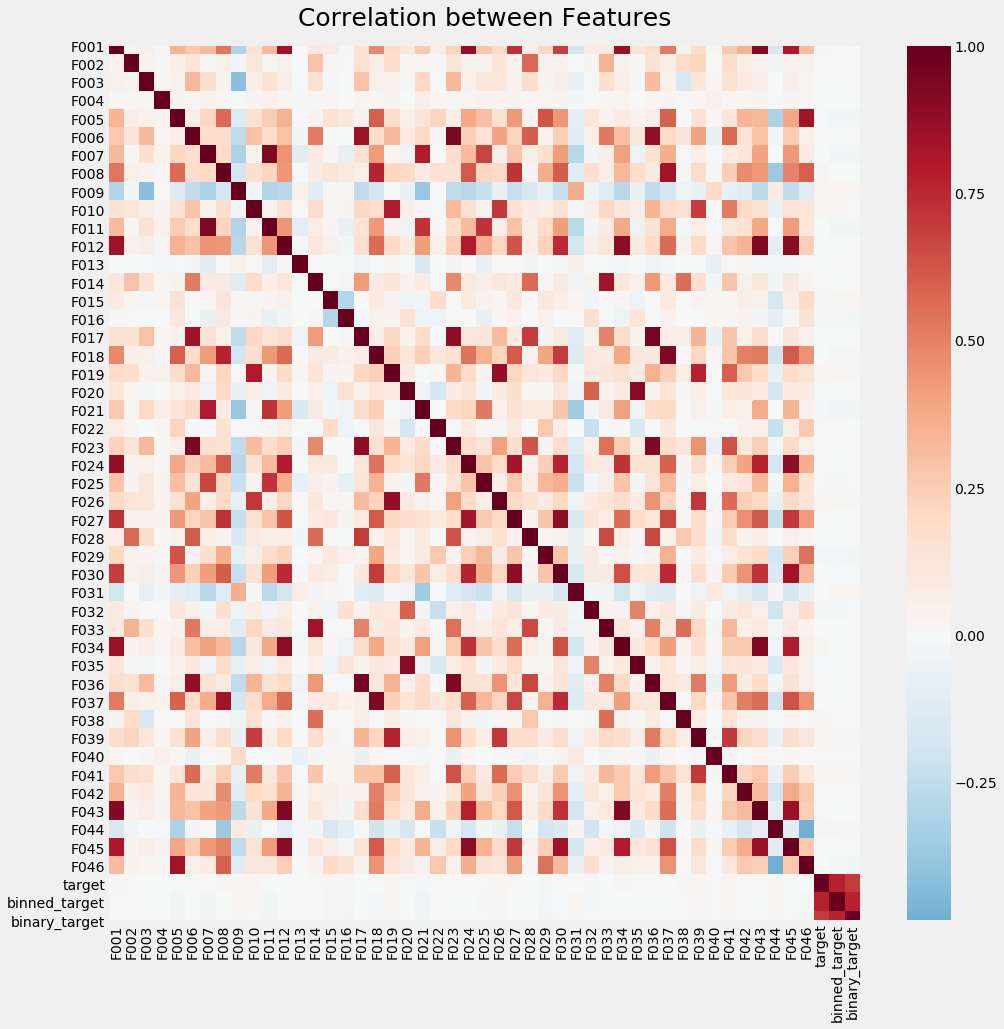

In [44]:
# 데이터셋의 Correlation 시각화
plt.figure(figsize=(15,15))
cols = feat_cols + ['target', 'binned_target', 'binary_target']
sns.heatmap(train_df[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('Correlation between Features', fontsize=25, pad=20)
plt.show()

피쳐가 비식별화 되어 있기 때문에 파악하기는 힘들지만, 특정 피쳐 간의 상관관계가 강한 것이 여럿 보인다. 
<br>
특이한 것은 예측하고자 하는 target과 feature간의 어떤 correlation도 존재하지 않는다는 것이다.
<br>
이 때문에 요즘 많은 사람들이 non linearity를 학습할 수 있는 딥러닝을 많이 적용하는 것으로 예상 된다.
<br>

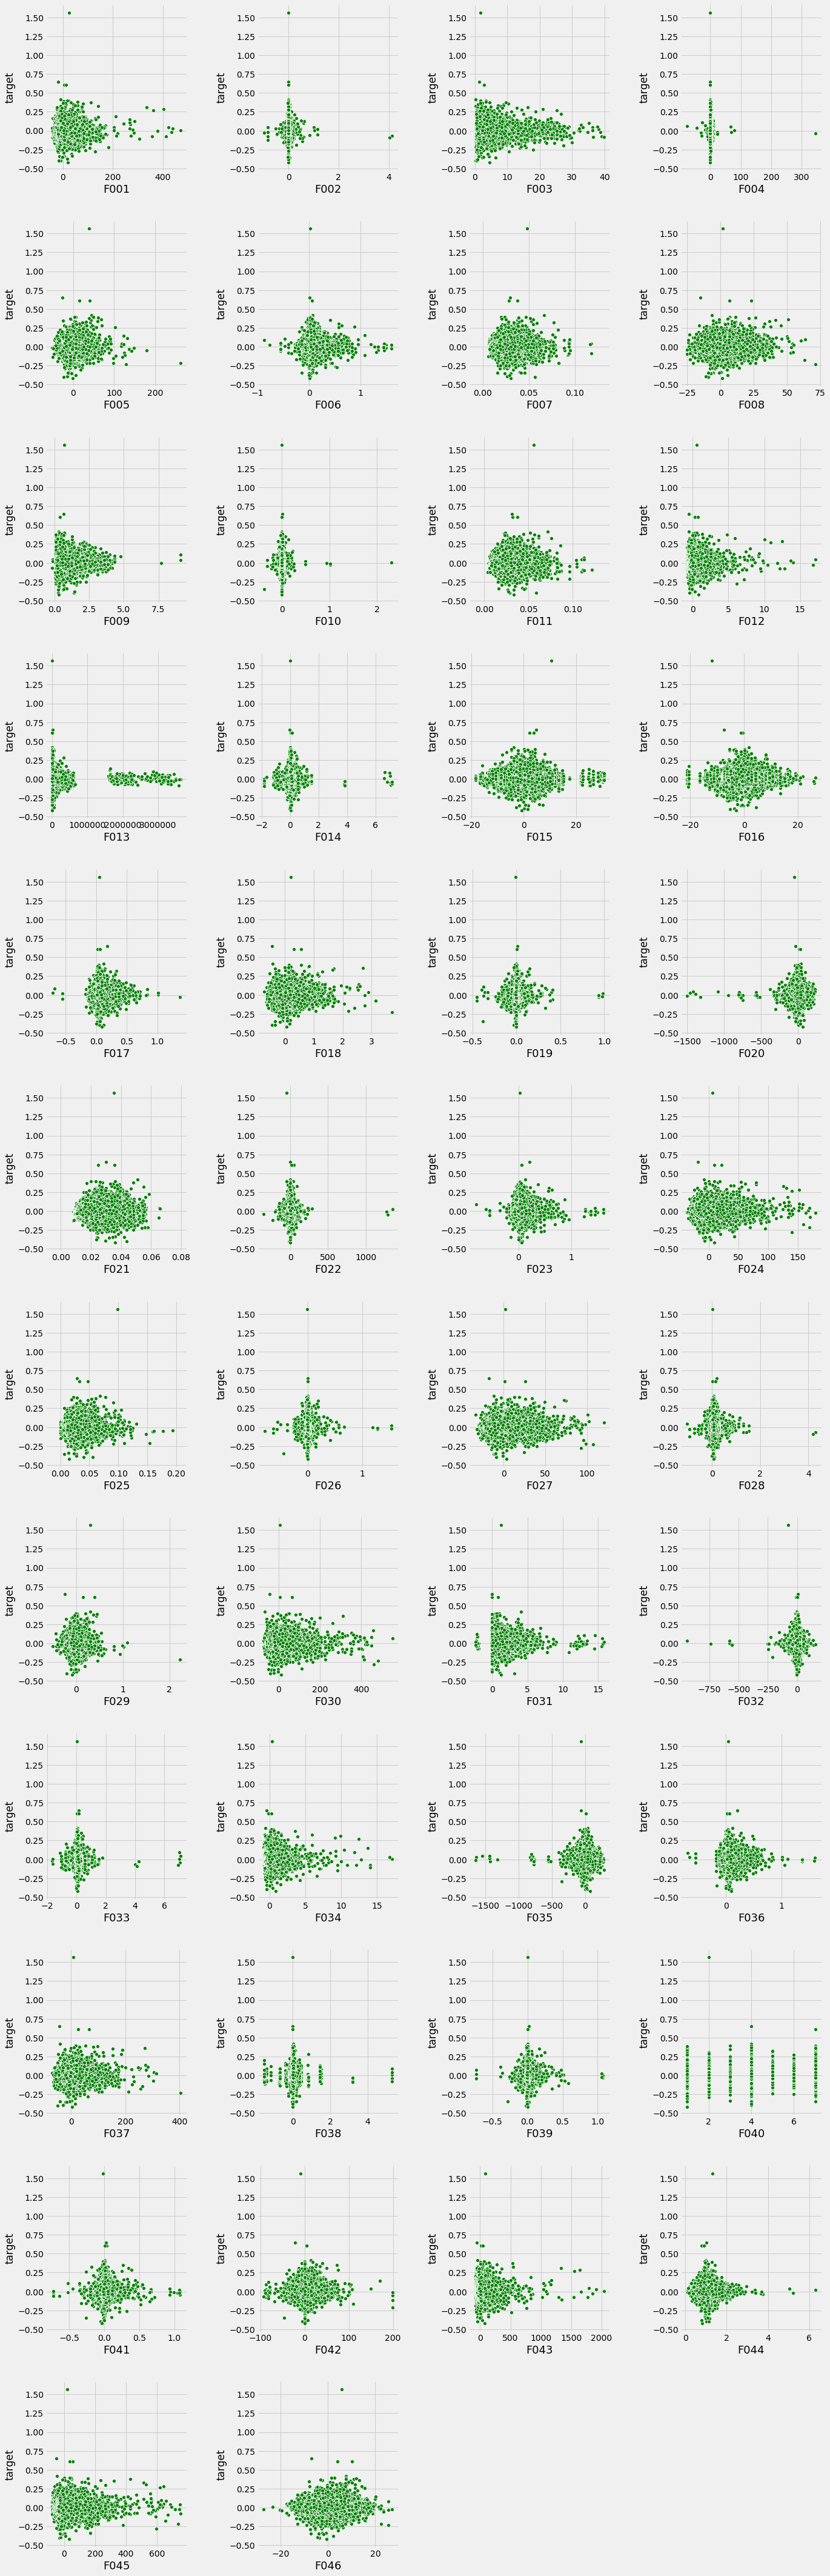

In [45]:
# 피쳐 칼럼들과 target 간의 산점도 시각화
col = 4
row = len(feat_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, feat_col in enumerate(feat_cols):
    plt.subplot(row, col, i+1)
    sns.scatterplot(x=feat_col, y='target', data=train_df.dropna(), color='green')
    plt.xlabel(feat_col, fontsize=18)
    plt.tight_layout(pad=3.0)
plt.show()

상관관계 시각화에서 살펴 봤듯이, 피쳐들은 target과 relation이 거의 존재하지 않는다. F40 피쳐 같은 경우 이산적인 값을 가지는 것으로 확인된다.

## 5.14 F feature 탐색

아래와 같이 시간에 따른 각각의 feature의 추세를 눈으로 확인할 수 있다.

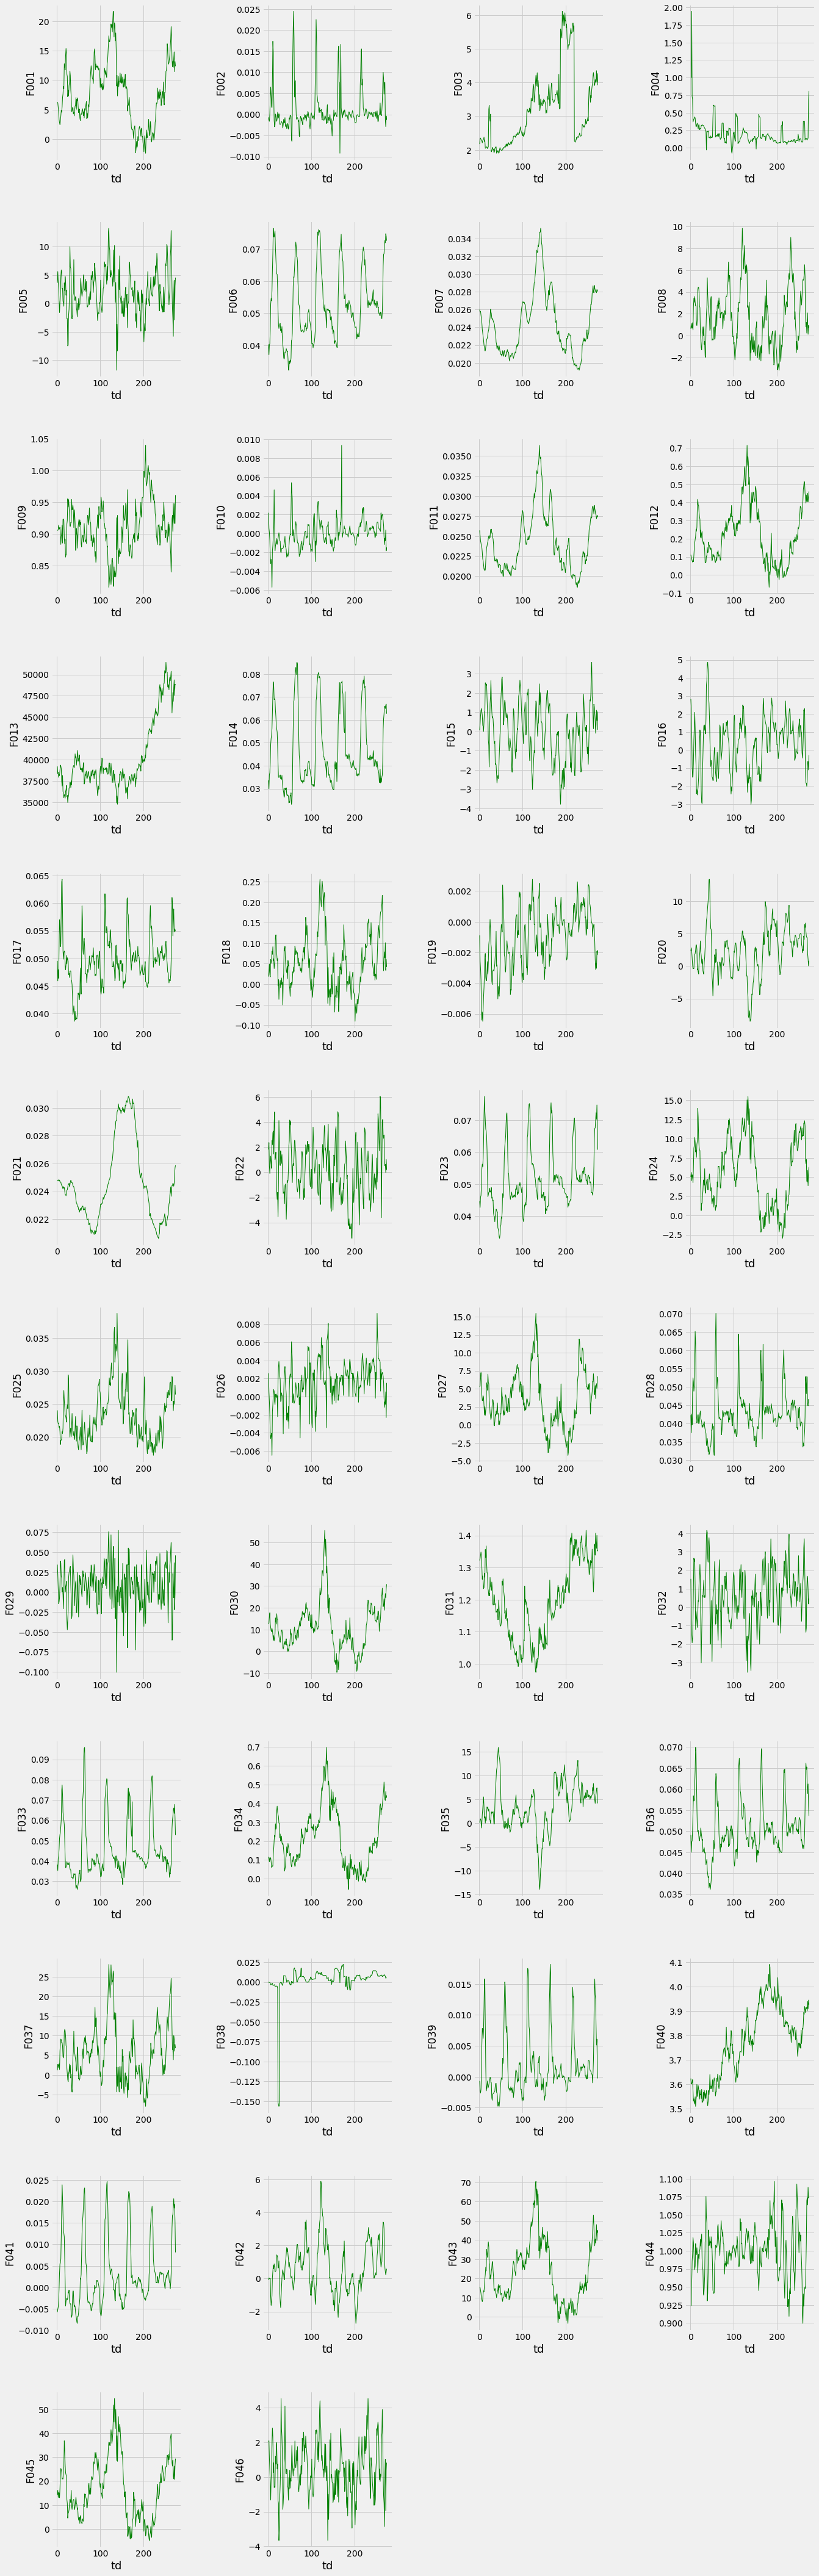

In [46]:
# 시간 단위 별로 각각의 feature 평균 시각화
col = 4
row = len(feat_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, feat_col in enumerate(feat_cols):
    plt.subplot(row, col, i+1)
    temp_df = train_df.groupby(['td'])[feat_col].mean().to_frame().reset_index()

    sns.lineplot(x='td', y=feat_col, data=temp_df, linestyle='--', linewidth=1, color='green')
    plt.xlabel('td', fontsize=18)
    plt.tight_layout(pad=4.0)

plt.show()

## 5.15 종목별, 시간 단위별 시각화

part 5.14와 같이 시간 단위 별로 각각의 feature를 시각화 해볼수도 있겠지만,
<br>
각각의 code(종목) 별로 feature를 살펴보는 것이 code별 특성을 파악하는데 도움될 것이다.

In [47]:
code = 'A005'

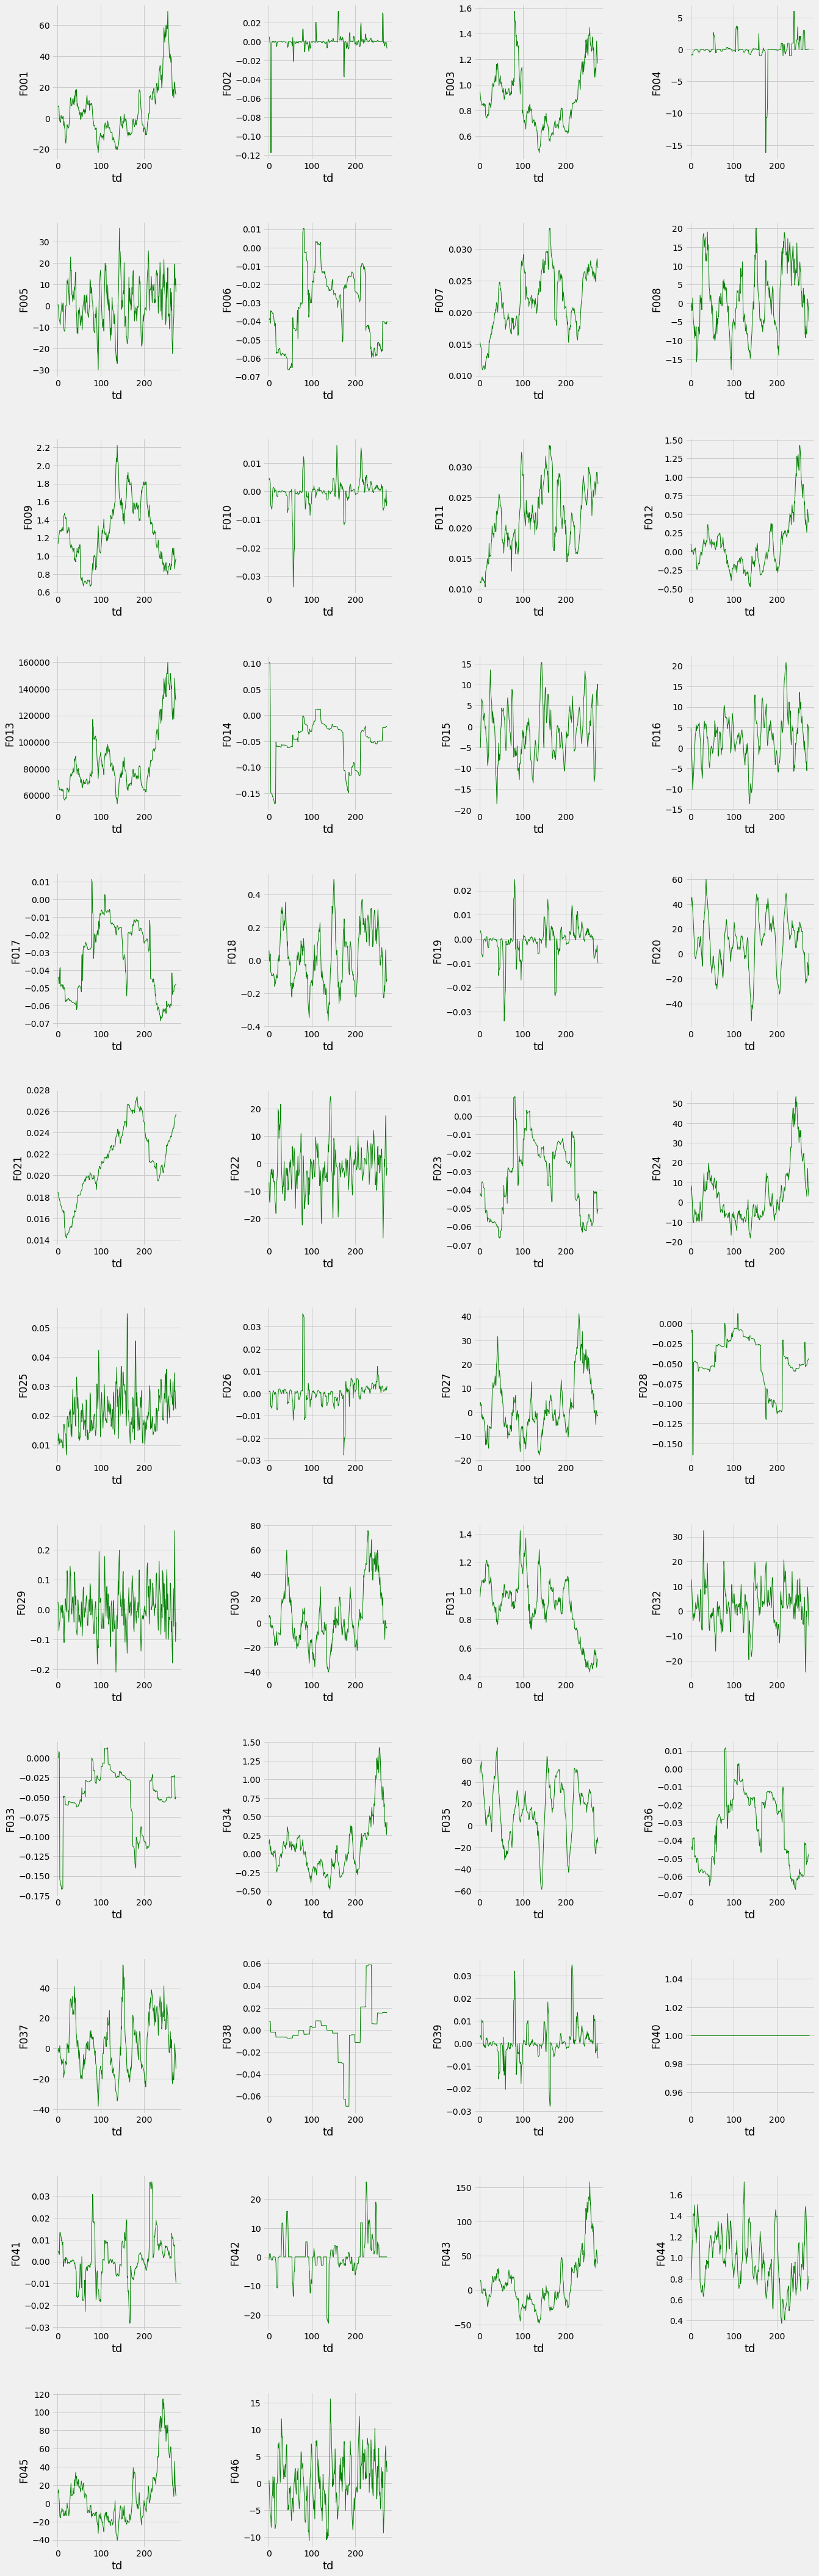

In [48]:
# code (종목) 별로 각각의 feature 시각화
col = 4
row = len(feat_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, feat_col in enumerate(feat_cols):
    plt.subplot(row, col, i+1)
    temp_df = train_df[train_df['code'] == code].reset_index(drop=True)

    sns.lineplot(x='td', y=feat_col, data=temp_df, linestyle='--', linewidth=1, color='green')
    plt.xlabel('td', fontsize=18)
    plt.tight_layout(pad=4.0)

plt.show()

혹은 code (종목) 간에 같은 feature를 시각화 해볼수도 있다.

In [49]:
# 비교하고자 하는 feature와 code 입력
feat_col = 'F001'
code_cols = ['A005', 'A007', 'A012', 'A793', 'A794', 'A795', 'A796']

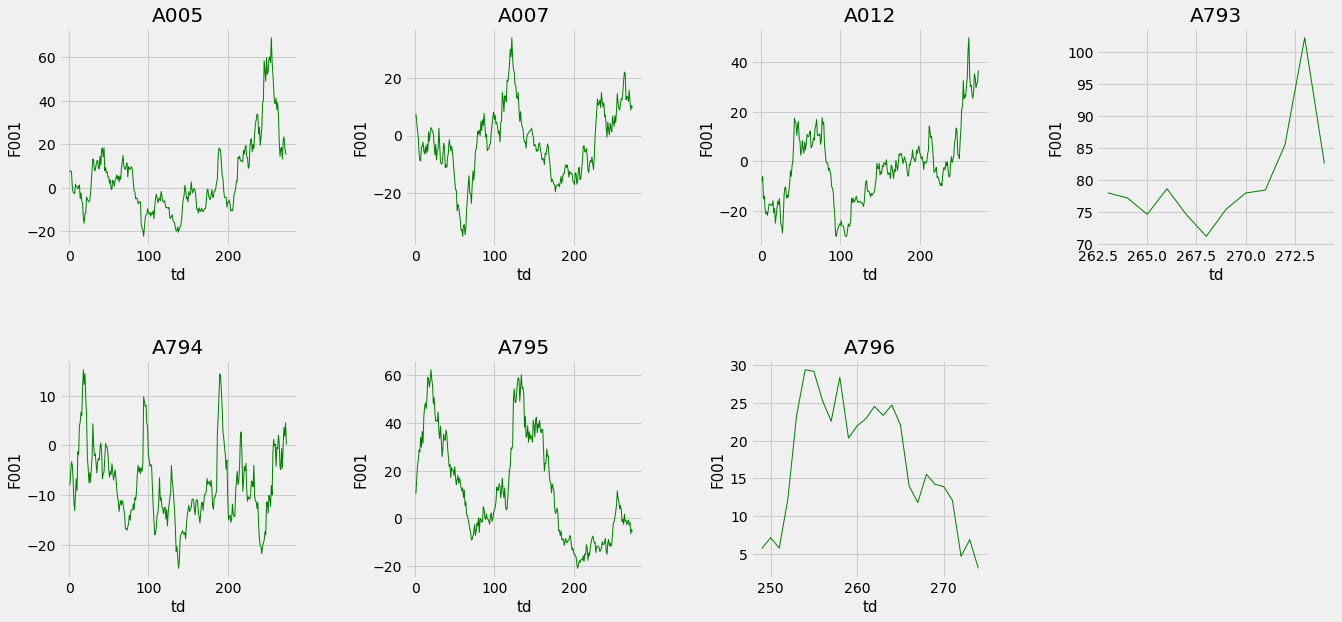

In [50]:
col = 4
row = len(code_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, code in enumerate(code_cols):
    plt.subplot(row, col, i+1)
    temp_df = train_df[train_df['code'] == code]
    sns.lineplot(x='td', y=feat_col, data=temp_df, linestyle='--', linewidth=1, color='green')
    plt.title(code)
    plt.xlabel('td', fontsize=15)
    plt.ylabel(feat_col, fontsize=15)
    plt.tight_layout(pad=4.0)
    
plt.show()

## 5.16 train, test feature 분포 비교

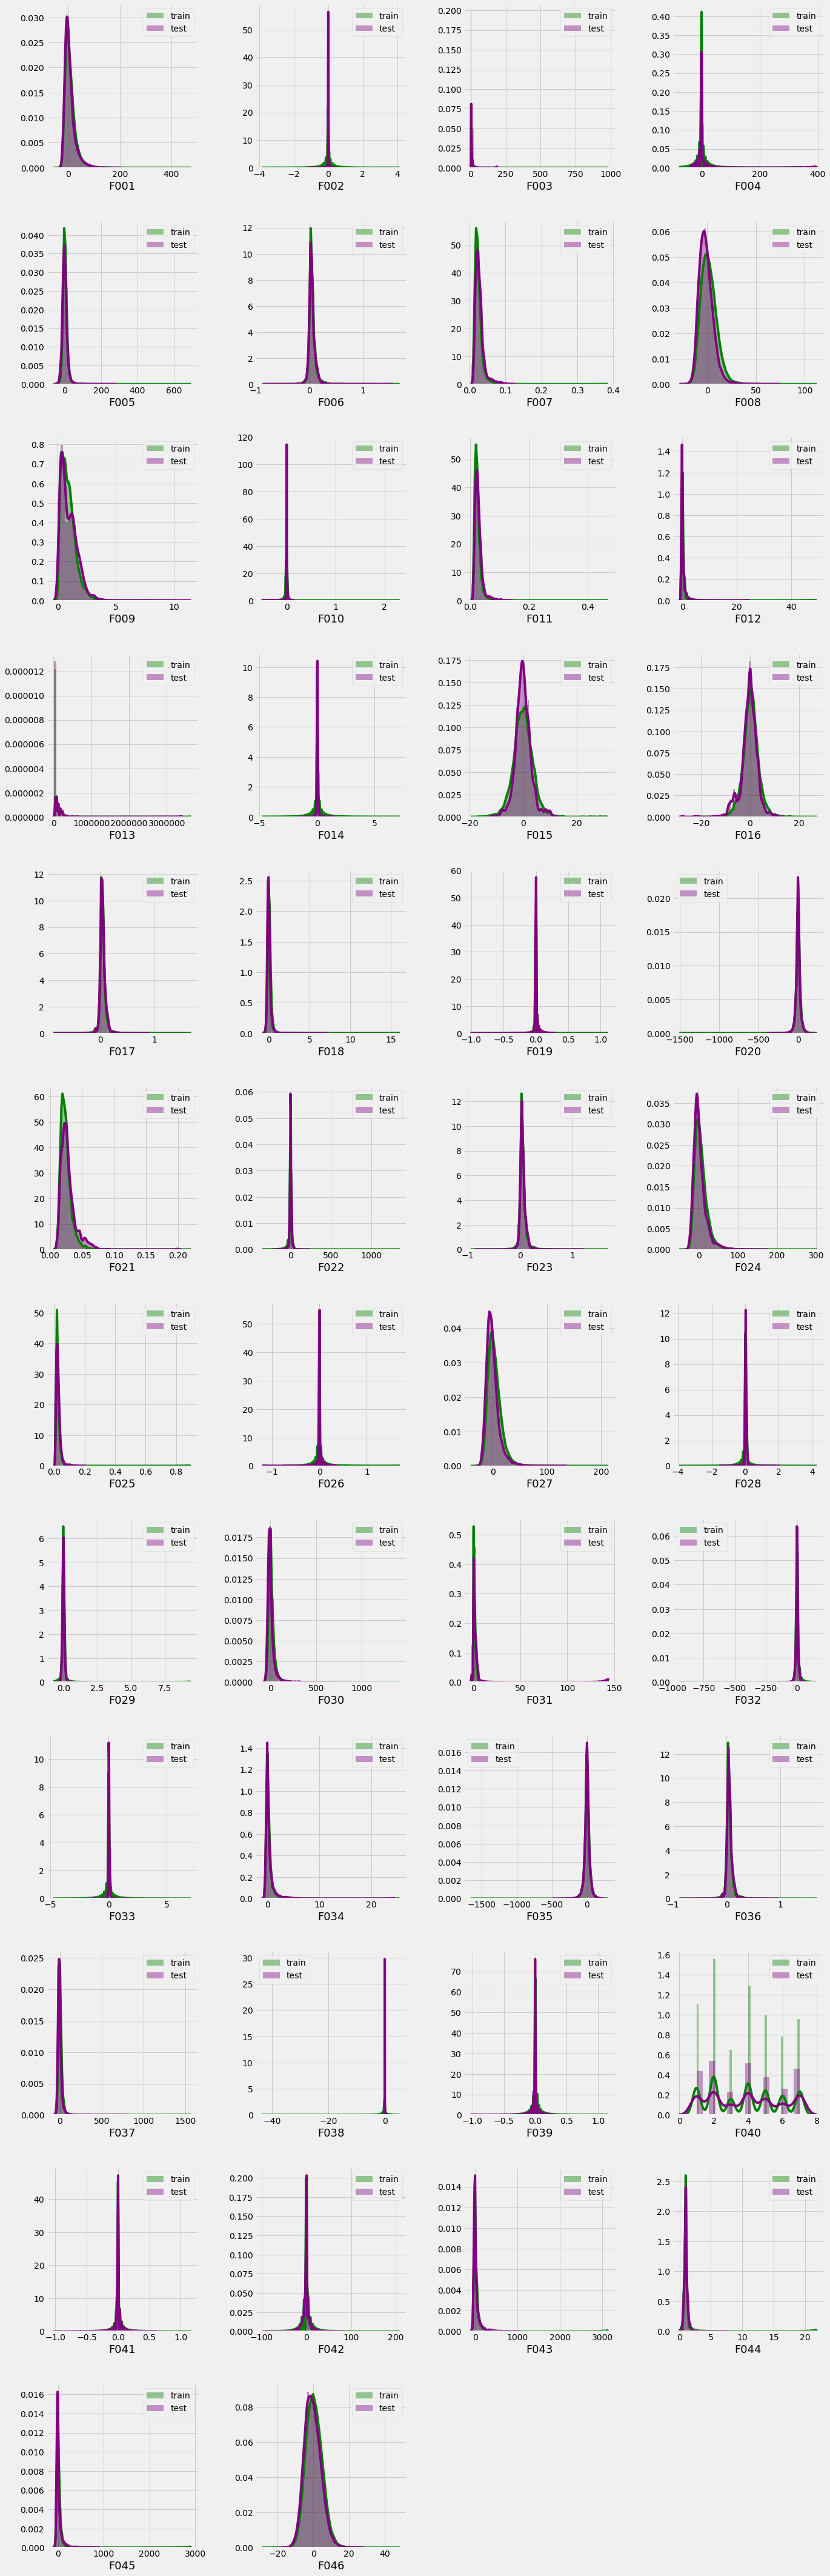

In [51]:
# 피쳐 칼럼들의 train, test 분포 시각화
col = 4
row = len(feat_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, feat_col in enumerate(feat_cols):
    plt.subplot(row, col, i+1)
    sns.distplot(train_df[feat_col].dropna(), color='green')
    sns.distplot(test_df[feat_col].dropna(), color='purple')
    plt.xlabel(feat_col, fontsize=18)
    plt.tight_layout(pad=3.0)
    plt.legend(['train', 'test'])
plt.show()

이렇게 train과 test 데이터의 분포가 유사한 것을 확인할 수 있다.
<br>
특정 피쳐의 train과 test 분포가 크게 다를 경우 처리를 해줘야겠지만, 이런 경우에는 validation 셋만 적절히 잘 나눠주면 된다.
<br>
또한 몇몇의 feature는 scale이 다르기 때문에 학습 전에 standardization을 통해 처리를 해줘야 한다.
<br>

## 5.17 Adversarial Validation

시계열 데이터, 특히 주식은 예측이 거의 불가능하다는 말이 나올 정도로 매우 어려운 과제이다
<br>
간단히 생각해봐도, 주식에 영향을 끼치는 요소가 너무 많기 때문에 어렵다는 생각이 든다.
<br>
어려움의 정도를 직접 수치로 확인하고자 한다.
<br>
<br>
**Adversarial Validation**이라는 기법을 적용함으로써 미래의 데이터인 test 셋이 어느 정도 예측될지 가늠해 보고자 한다.
<br>
다음 링크는 본인이 간략하게 정리한 글이다.
<br>
https://www.notion.so/saewonyang/Covariate-Shift-Unearthing-hidden-problems-in-Real-World-Data-Science-793c82672d4a430b89fadca059ef8c77

아이디어를 요약하면 다음과 같다.
1. train set과 test set에 각각 bool type인 'isTest' 칼럼을 추가한다.
2. train set과 test set을 하나의 데이터셋으로 합친다.
3. 해당 데이터가 train set인지 test set인지 예측하는 이진분류 모델을 학습한다.
4. 만약에 train set과 test set의 분포가 매우 유사하다면, 모델은 auc 값이 0.5 근처에 나와야 한다. 
<br> auc 값이 1.0 가까이 갈수록 train set과 test set의 분포가 다르다는 것을 보여준다

In [52]:
temp_train_df = train_df.copy()
temp_test_df = test_df.copy()
temp_train_df['is_test'] = 0
temp_test_df['is_test'] = 1

feat_cols = feat_cols + ['is_test']

train_test = pd.concat([temp_train_df[feat_cols], temp_test_df[feat_cols]], axis =0)
target = train_test['is_test'].values

use_cols = [col for col in train_test.columns if col not in 'is_test']

In [53]:
train_test['is_test'].value_counts()

0    83469
1    11618
Name: is_test, dtype: int64

In [54]:
# lgbm model hyper parameters
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth':3,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 17,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_test))

In [55]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_test.values, target)):
    print("fold_num {}".format(fold_))
    trn_data = lgb.Dataset(train_test.iloc[trn_idx][use_cols], label=target[trn_idx])
    val_data = lgb.Dataset(train_test.iloc[val_idx][use_cols], label=target[val_idx])

    num_round = 3000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 50)
    oof[val_idx] = clf.predict(train_test.iloc[val_idx][use_cols], num_iteration=clf.best_iteration)

fold_num 0
Training until validation scores don't improve for 50 rounds
[500]	training's auc: 0.832079	valid_1's auc: 0.829861
[1000]	training's auc: 0.869671	valid_1's auc: 0.864781
[1500]	training's auc: 0.892759	valid_1's auc: 0.885821
[2000]	training's auc: 0.909074	valid_1's auc: 0.900792
[2500]	training's auc: 0.921158	valid_1's auc: 0.911687
[3000]	training's auc: 0.930442	valid_1's auc: 0.920014
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.930442	valid_1's auc: 0.920014
fold_num 1
Training until validation scores don't improve for 50 rounds
[500]	training's auc: 0.833594	valid_1's auc: 0.826679
[1000]	training's auc: 0.871446	valid_1's auc: 0.859555
[1500]	training's auc: 0.893708	valid_1's auc: 0.87848
[2000]	training's auc: 0.909745	valid_1's auc: 0.892709
[2500]	training's auc: 0.921948	valid_1's auc: 0.903473
[3000]	training's auc: 0.931438	valid_1's auc: 0.912013
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.931438	val

In [56]:
oof_score = roc_auc_score(train_test['is_test'], oof)
print("Average ROC-AUC score: {:.4f}".format(oof_score))

Average ROC-AUC score: 0.9137


결과를 보면 roc auc 값이 쉽게 0.9 이상이 나온다.
<br>
train과 test의 시간 단위가 다르기 때문에 이것은 당연한 결과라고 할 수 있다.

## 5.18 이진 분류 시각화

지금까지는 regression으로 문제를 한정하여 시각화를 해봤다.
<br>
이진분류로 문제를 바꾸어 시각화를 진행해보자.

In [64]:
# 이진 분류 문제로 바꾸어 positive와 negative로 나누어서 살펴보자
pos_df = train_df.loc[train_df['binary_target'] == 1].reset_index(drop=True)
neg_df = train_df.loc[train_df['binary_target'] == 0].reset_index(drop=True)
feat_cols.remove('is_test')

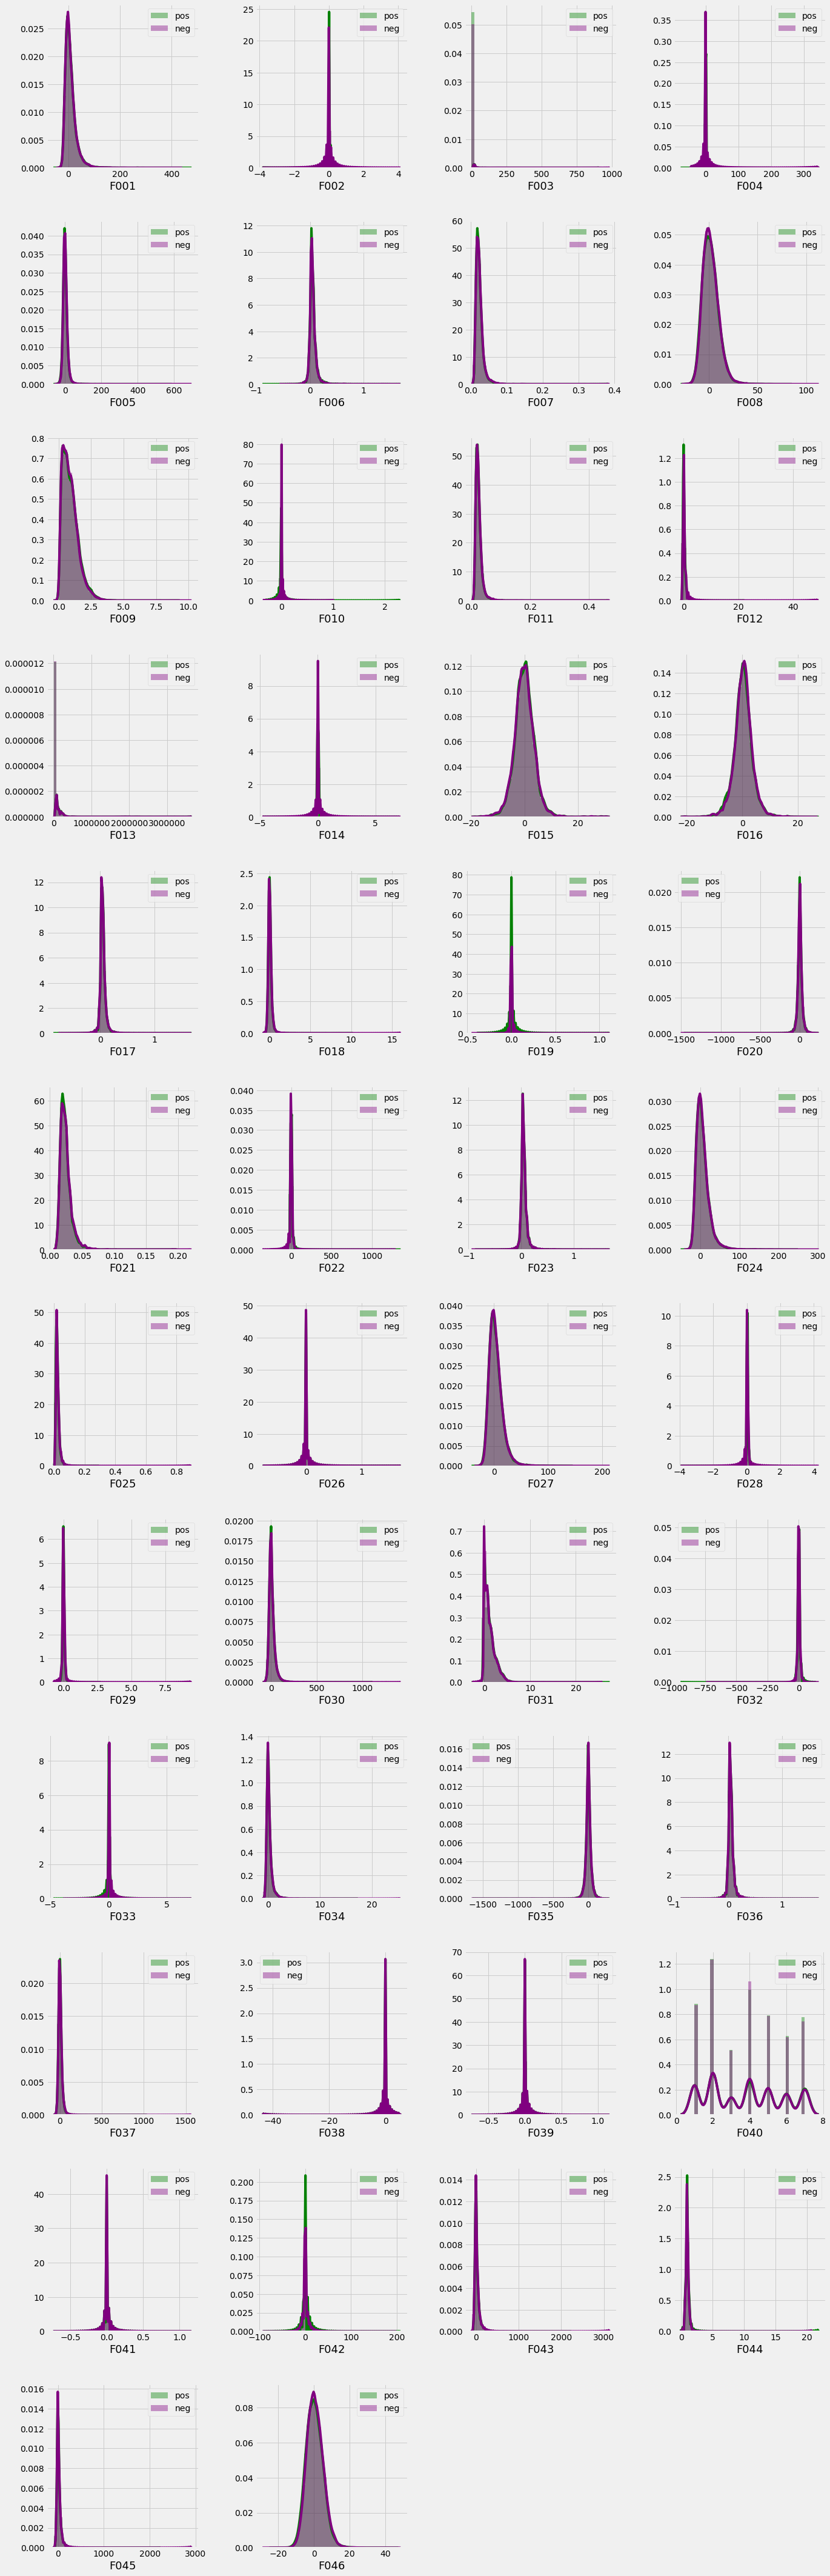

In [65]:
# 피쳐 칼럼들의 positive, negative target 분포 시각화
col = 4
row = len(feat_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, feat_col in enumerate(feat_cols):
    plt.subplot(row, col, i+1)
    sns.distplot(pos_df[feat_col].dropna(), color='green')
    sns.distplot(neg_df[feat_col].dropna(), color='purple')
    plt.xlabel(feat_col, fontsize=18)
    plt.tight_layout(pad=3.0)
    plt.legend(['pos', 'neg'])

plt.show()

분포를 보면 알 수 있듯이, 이진분류로 바꿨음에도 불구하고 positive와 negative 샘플 간의 분포가 매우 유사하다.
<br>
해결하기 매우 어려운 과제임을 알 수 있다.

## 5.19 PCA를 활용한 시각화

In [ ]:
# 전체 데이터셋의 약 10%를 샘플링하여 시각화 진행
temp_df = train_df.sample(frac=0.1).reset_index(drop=True)

pca_data = pca_apply(temp_df, feat_cols, 'binary_target')

trace1 = pca_trace("Up",'red')
trace2 = pca_trace("Down",'royalblue')
data = [trace2,trace1]

layout = go.Layout(dict(title = "<b>Visualize Dataset using PCA<b>",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

PCA를 활용하여 feature들을 2개의 component로 압축하여 시각화를 진행해봤다.
<br>
보통 해결하기 쉬운 과제일 경우, 이런식으로 시각화를 진행했을 시에 눈으로도 잘 구별이 된다.
<br>
하지만 부여 받은 과제는 이진분류조차 힘들어 보인다.

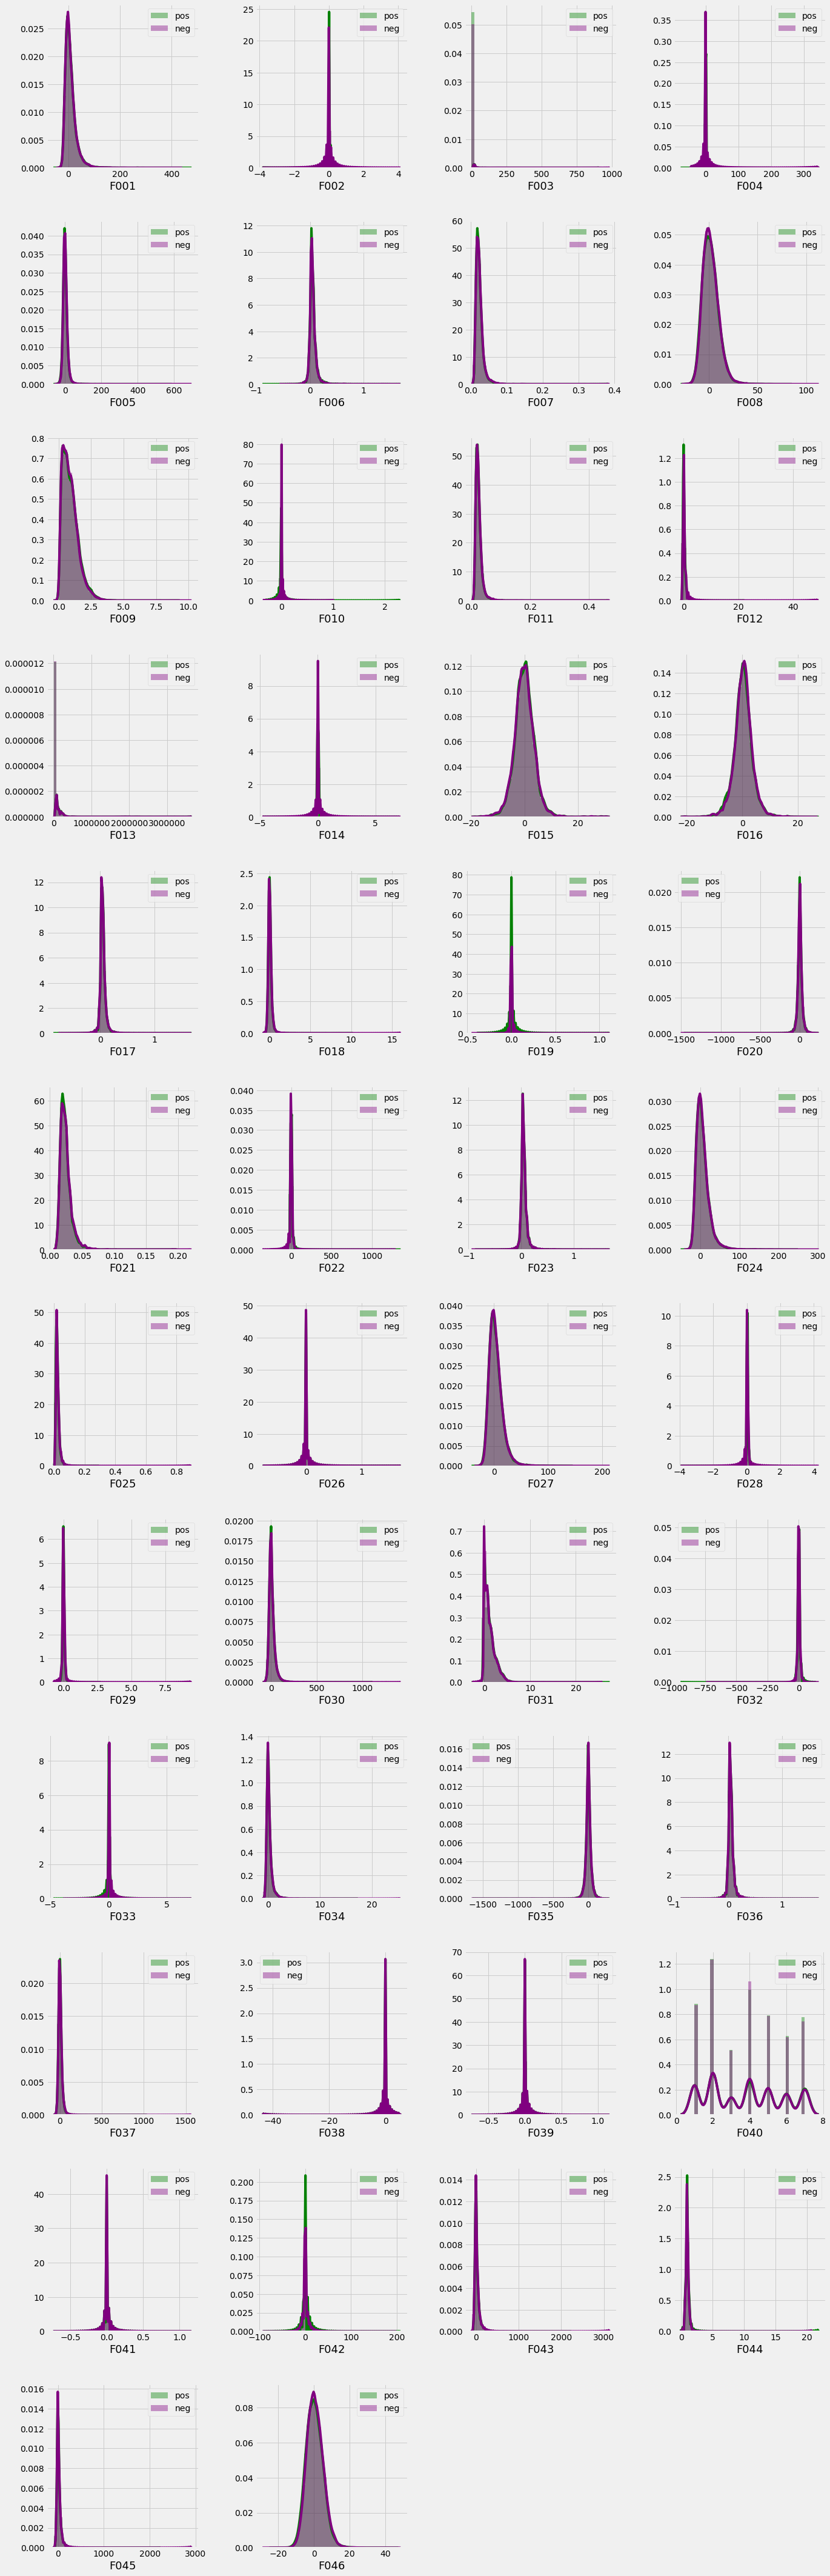

In [66]:
# 피쳐 칼럼들의 positive, negative target 분포 시각화
col = 4
row = len(feat_cols)//4+1
plt.figure(figsize=(20,row*5))

for i, feat_col in enumerate(feat_cols):
    plt.subplot(row, col, i+1)
    sns.distplot(pos_df[feat_col].dropna(), color='green')
    sns.distplot(neg_df[feat_col].dropna(), color='purple')
    plt.xlabel(feat_col, fontsize=18)
    plt.tight_layout(pad=3.0)
    plt.legend(['pos', 'neg'])

## 5.20 이진분류 code별 target 시각화

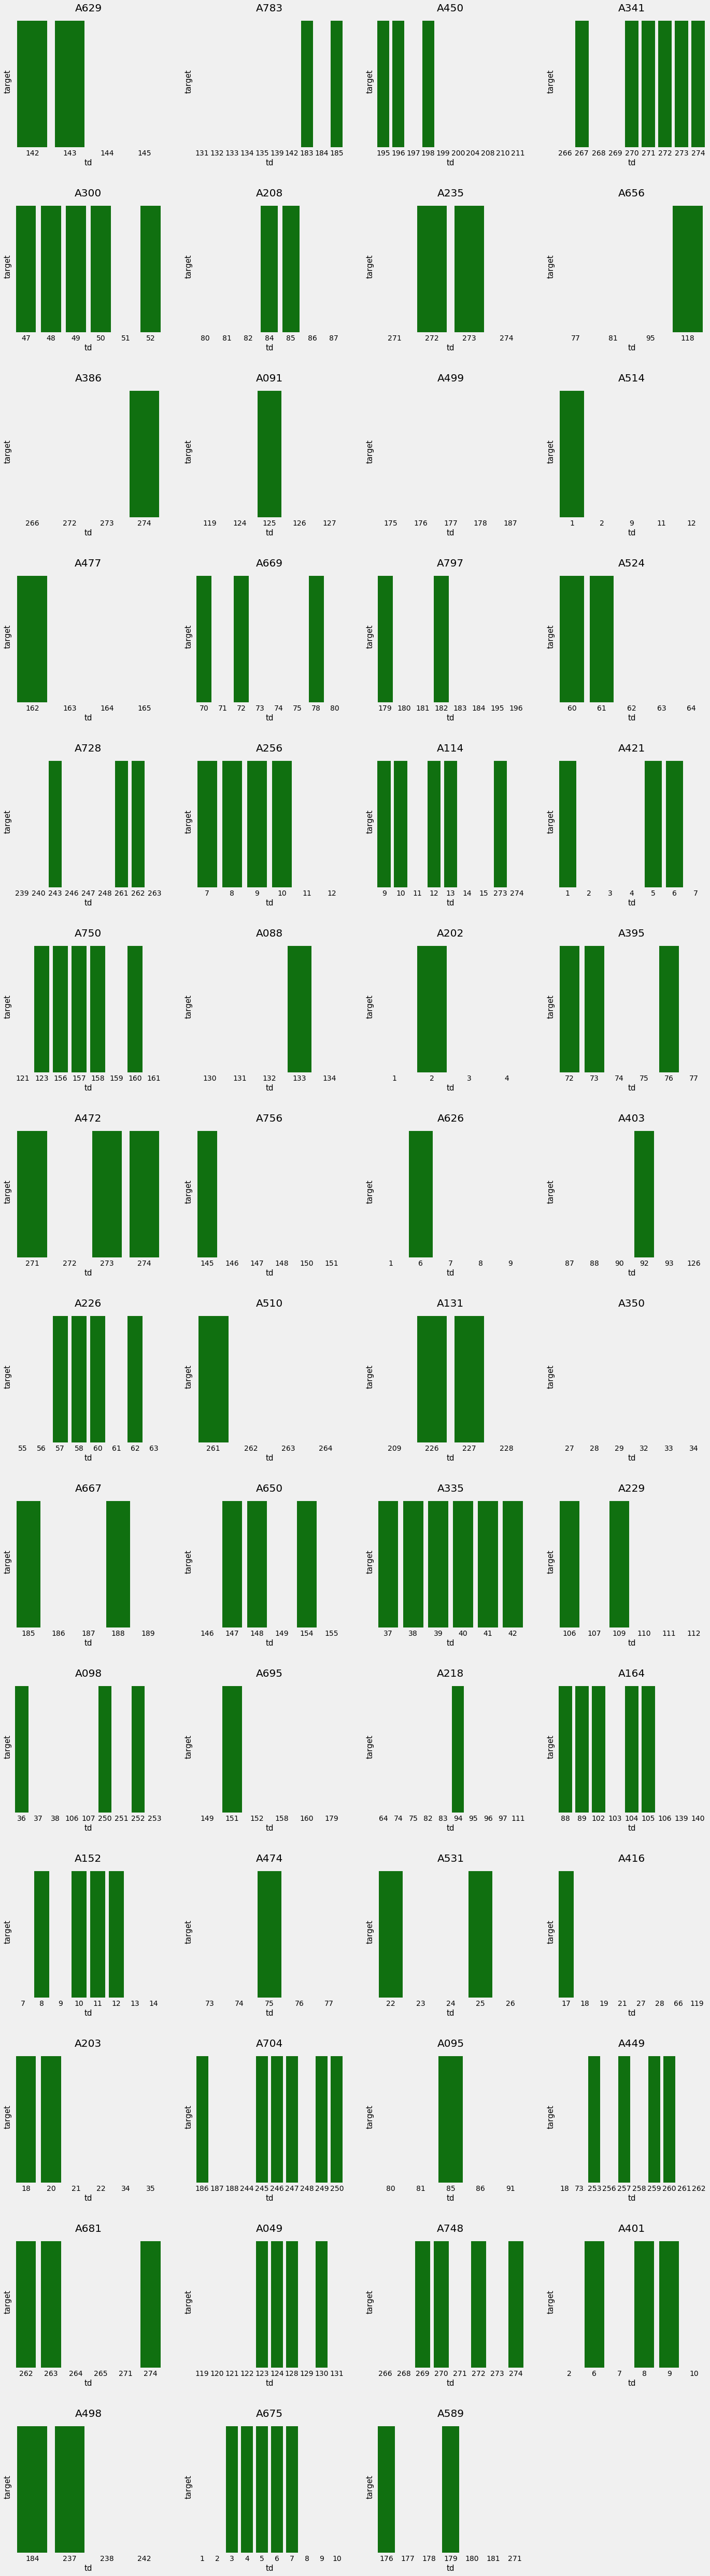

In [67]:
# td <= 10의 이진분류 target 시각화
temp_dict = Counter(train_df['code'])
code_freq_under_10 = [k for k, v in set(temp_dict.items()) if v <= 10]

col = 4
row = len(code_freq_under_10)//4+1
plt.figure(figsize=(20,row*5))
for i, code in enumerate(code_freq_under_10):
    plt.subplot(row, col, i+1)
    temp_df = train_df[train_df['code']==code]
    sns.barplot(x='td', y='binary_target', data=temp_df, color='green')    
    plt.title(code)
    plt.xlabel('td', fontsize=15)
    plt.ylabel('target', fontsize=15)
#     plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=3.0)


code (종목) 별로 binary target을 시각화 해볼 수 있다.
<br>
10번 이하로 등장하는 종목들을 시각화 해보면 위와 같다.
<br>
어떤 종목은 수익률이 항상 양수인 반면에, 어떤 종목은 항상 음수인 것이 확인된다.
<br>
<br>
그렇다면 많이 등장하는 종목들은 어떠할까?
시간 단위 274 td 내내 등장하는 종목들을 30개만 살펴보자 

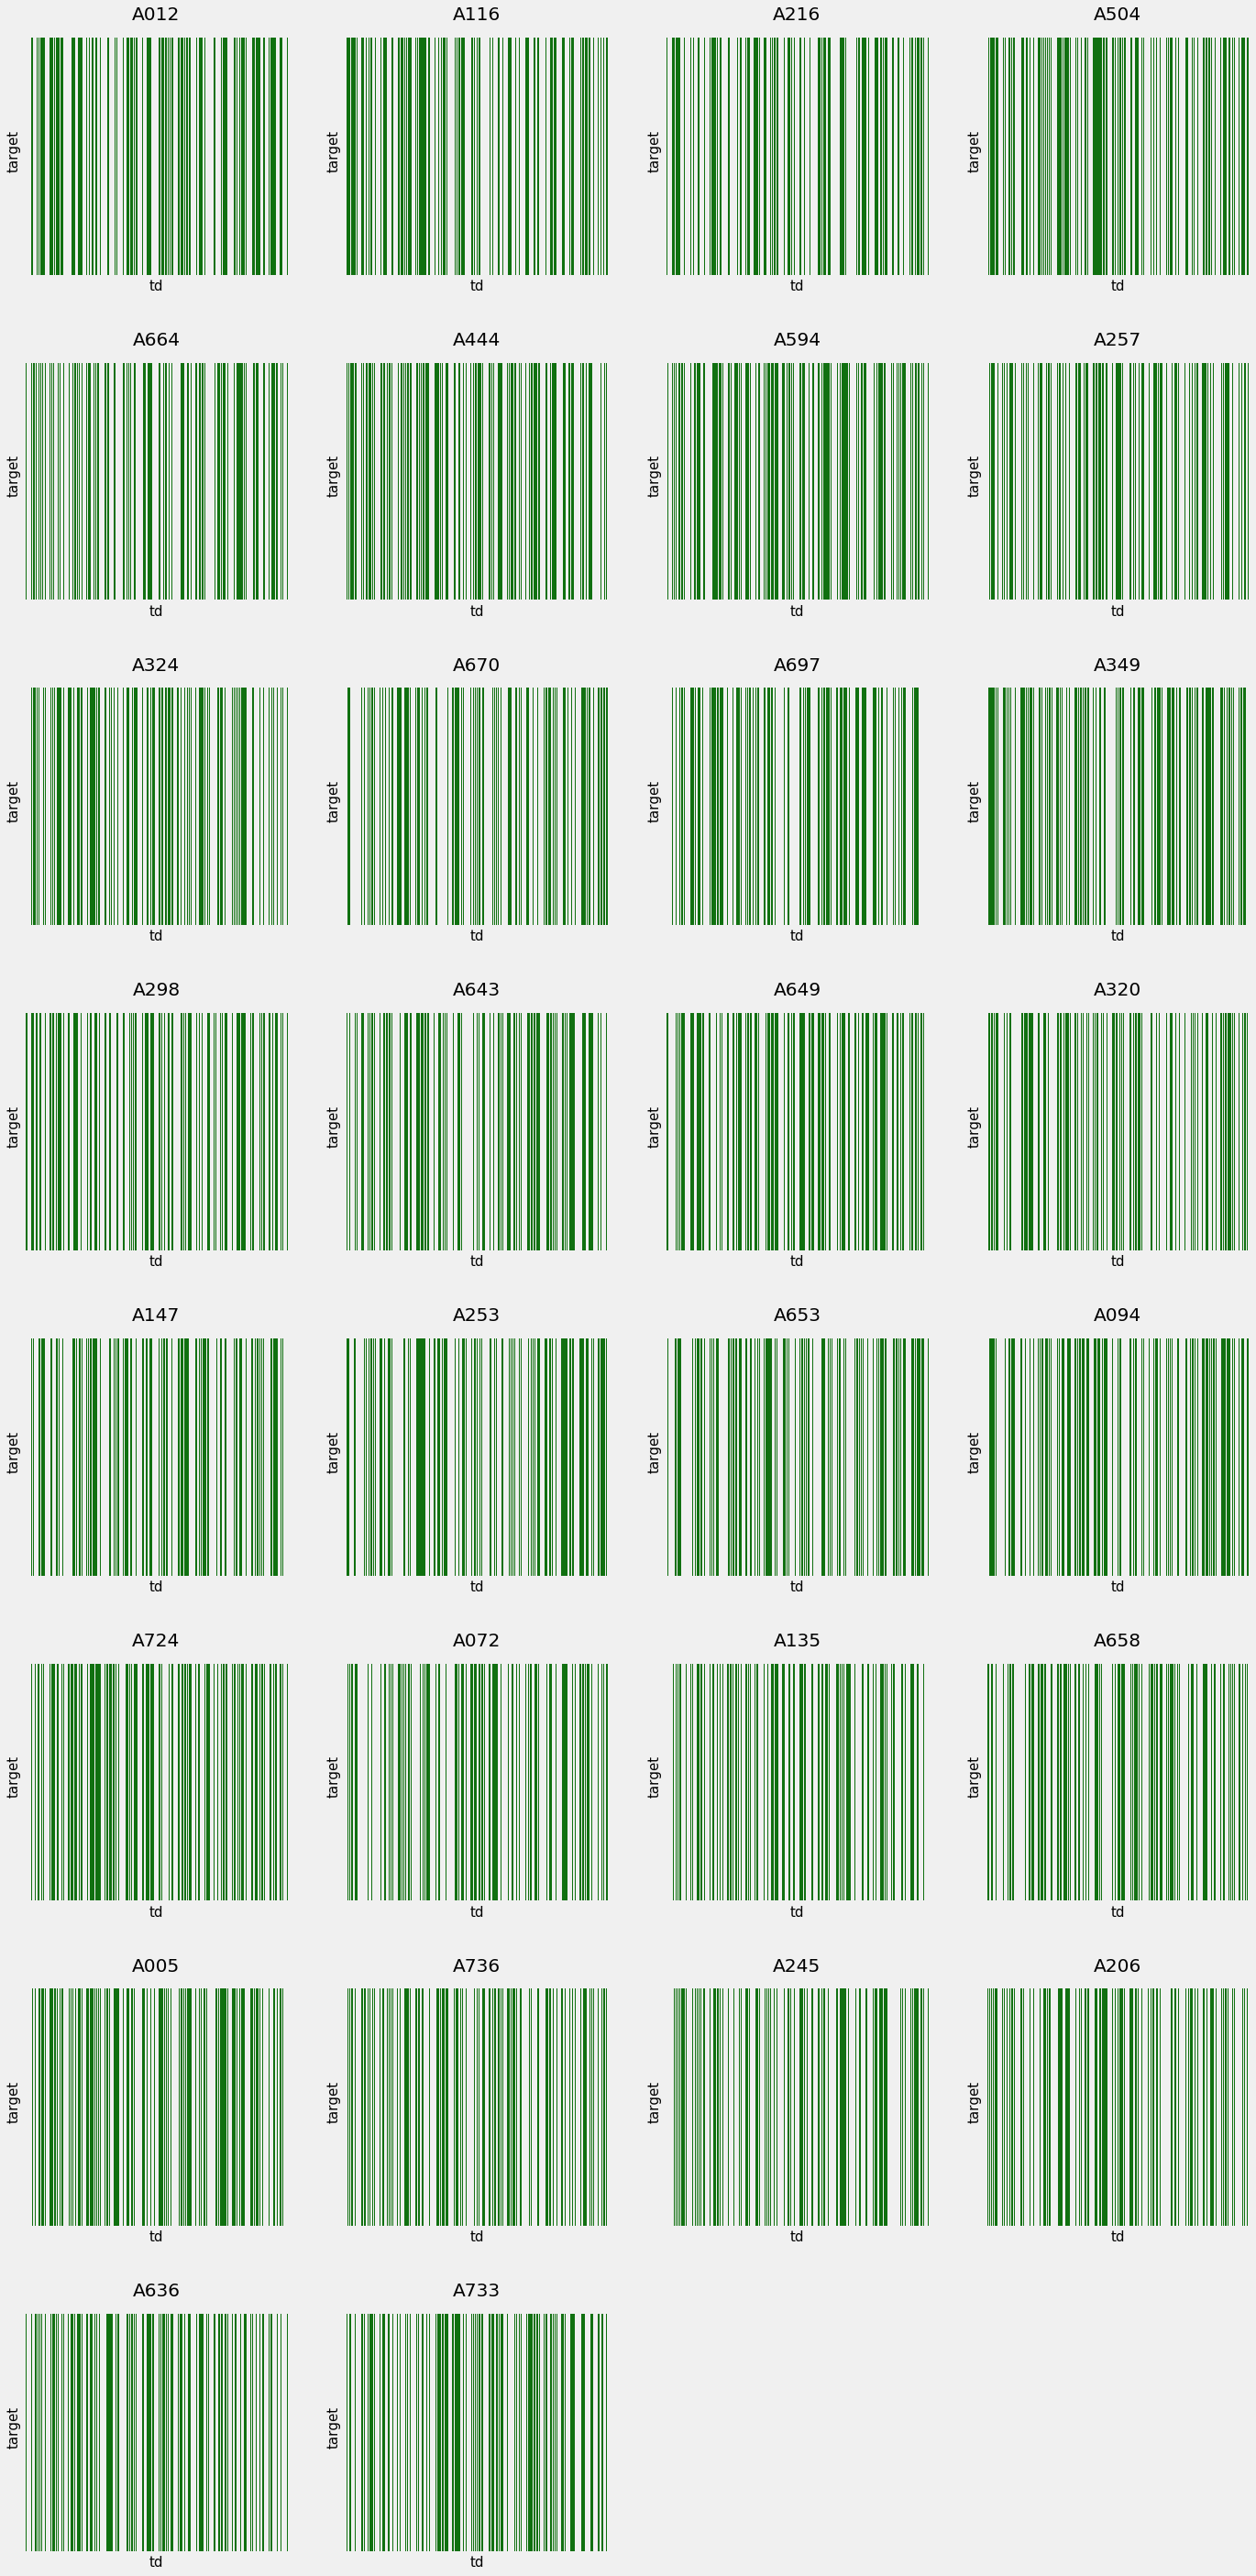

In [68]:
# td == 274의 이진분류 target 시각화
temp_dict = Counter(train_df['code'])
code_freq_274 = [k for k, v in set(temp_dict.items()) if v == 274]

col = 4
row = len(code_freq_274[:30])//4+1
plt.figure(figsize=(20,row*5))
for i, code in enumerate(code_freq_274[:30]):
    plt.subplot(row, col, i+1)
    temp_df = train_df[train_df['code']==code]
    sns.barplot(x='td', y='binary_target', data=temp_df, color='green')    
    plt.title(code)
    plt.xlabel('td', fontsize=15)
    plt.ylabel('target', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=3.0)

값이 있는 부분은 수익률이 0 이상, 즉 1 라벨이고, 비어 있는 부분은 수익률이 0 이하인 0 라벨이다.
<br>
시각화해 본 결과, 기간 내내 항상 수익률이 0 이상인, 혹은 0 이하인 종목은 존재하지 않는다.
<br>
간혹가다 특정 부분에서 수익률이 내내 양수 혹은 음수 패턴을 보이기도 하는데,
<br>
이러한 복잡한 패턴을 예측하고자 하는 것이 우리의 목표가 될 것이다.

## 5.21 train, test code 비교

<br>
train set에는 등장하지만, test set에는 등장하지 않는 code (종목)을 비교해보자.
<br>

In [69]:
train_code_list = set(train_df['code'].tolist())
test_code_list = set(test_df['code'].tolist())

In [70]:
print("number of codes in train: {}".format(len(train_code_list)))
print("number of codes in test: {}".format(len(test_code_list)))

number of codes in train: 610
number of codes in test: 403


In [71]:
test_code_not_in_train = test_df[~test_df['code'].isin(train_code_list)]['code'].unique()

In [72]:
print("number of codes in test that are not in train: {}".format(len(test_code_not_in_train)))

number of codes in test that are not in train: 33


In [73]:
# NaN analysis per code

NaN_dict = {}

for code in test_code_not_in_train:
    temp_df = test_df[test_df['code'] == code]
    null_num = temp_df.isnull().sum().sum()
    feat_num = temp_df[feat_cols].shape[0] * temp_df[feat_cols].shape[1]
    uniqeu_td_num = len(temp_df)
    NaN_dict[code] = [null_num, np.round((null_num/feat_num)*100, 2), feat_num, uniqeu_td_num]
    

In [74]:
temp_df = pd.DataFrame.from_dict(NaN_dict, orient='index').reset_index() \
                                .rename(columns={'index':'code', 0:'Nan_count', 1:'Nan_ratio', 2:'feat_num', 3:'unique_td_num'}) \
                                .sort_values(by='Nan_ratio', ascending=False).reset_index(drop=True)

In [75]:
temp_df

code  Nan_count  Nan_ratio  feat_num  unique_td_num
0   A686         68      73.91        92              2
1   A406        127      69.02       184              4
2   A575        118      64.13       184              4
3   A435        320      63.24       506             11
4   A351         29      63.04        46              1
5   A234        275      54.35       506             11
6   A703        111      48.26       230              5
7   A332        261      47.28       552             12
8   A248        282      47.16       598             13
9   A456        414      39.13      1058             23
10  A001        414      39.13      1058             23
11  A398        464      37.36      1242             27
12  A536        436      32.68      1334             29
13  A085         30      32.61        92              2
14  A061        195      32.61       598             13
15  A508        540      32.61      1656             36
16  A059         90      32.61       276              6
17  A213        540      32.61      1656             36
18  A402        405      32.61      1242             27
19  A657        270      32.61       828             18
20  A302         15      32.61        46              1
21  A570        330      32.61      1012             22
22  A671        195      32.61       598             13
23  A451         30      32.61        92              2
24  A027        331      31.29      1058             23
25  A782        487      29.41      1656             36
26  A282         44      23.91       184              4
27  A354         78       5.65      1380             30
28  A607         60       3.73      1610             35
29  A053          0       0.00       230              5
30  A800          0       0.00       230              5
31  A291          0       0.00        46              1
32  A081          0       0.00       736             16

위와 같이 train에는 없는 test 만의 고유 코드에 대해서 살펴보았다.
<br>
403개 중에 33개가 train에 존재하지 않기 때문에 이를 고려하여 feature engineering을 진행해야 할 것이다. 
<br>

# 6. Conclusion

- 모델링을 하는 것도 중요하지만, 데이터 탐색을 통해 도메인을 더 잘 이해해야 보다 정확한 모델링을 진행할 수 있을 것이다.
- EDA 과정을 통해 살펴본 결과, 해결하기 매우 어려운 문제임이 짐작할 수 있었고 다수의 논문을 살펴본 결과 이 문제를 이진분류 문제로 풀고 있기 때문에
  본인 또한 이진분류 문제로 단순화하여 모델링을 진행하고자 한다.